# Quels tendancent on les variables ?

In [1]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

## Charger les données d'entrainement

In [2]:
df_train = pd.read_csv("data/train.csv")

ids = df_train["ID"]
target = df_train["TARGET"]
features = df_train.drop(columns=["TARGET", "ID"], errors='ignore').copy()

## On va mettre à l'échelle les données

In [22]:
def clean_special_codes(df):
    df = df.copy()
    max_dict = df.max().to_dict()

    for col in df.columns:
        data = df[col]

        # Remplacer les NaN
        data = data.fillna(-1)

        max_val = max_dict[col]

        if max_val in [9, 99, 999]:
            # Valeurs "non réponse"
            data = data.replace(max_val, -1)

            # Valeurs "jamais fait / non concerné"
            if max_val == 9:
                data = data.replace([8, 7], 0)
            elif max_val == 99:
                data = data.replace([88, 77], 0)
            elif max_val == 999:
                data = data.replace([888, 777], 0)

        df[col] = data

    return df

features = clean_special_codes(features)

def clean_weight_to_lbs(series):
    series = series.copy()

    # Codes spéciaux
    series = series.replace({7777: 0, 9999: -1})

    # Cas 1 : poids déjà en livres
    lbs_mask = (series >= 1) & (series < 9000)

    # Cas 2 : poids en kg
    kg_mask = (series >= 9000) & (series < 9400)
    series.loc[kg_mask] = (series.loc[kg_mask] - 9000) * 2.20462  # conversion kg → lbs

    # Autres valeurs → NaN
    series.loc[~(lbs_mask | kg_mask)] = np.nan

    # Arrondir et convertir
    series = series.round().astype("Int64")

    return series

# Application sur ton DataFrame
features["WEIGHT2"] = clean_weight_to_lbs(features["WEIGHT2"])


In [23]:
features_nan = features.isna().sum(axis = 0) / len(features)
print(features_nan)

_STATE           0.0
FMONTH           0.0
IDATE            0.0
IMONTH           0.0
IDAY             0.0
                ... 
_RFDRHV8         0.0
_FLSHOT7         0.0
_PNEUMO3         0.0
_AIDTST4         0.0
WEIGHT2_CLEAN    0.0
Length: 324, dtype: float64


In [24]:
columns_of_interest = ['SEXVAR', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PRIMINSR', 'PERSDOC3', 'MEDCOST1', 'CHECKUP1', 'EXERANY2', 'SLEPTIM1', 'LASTDEN4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'DIABETE4', 'WEIGHT2', 'HEIGHT3', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'USENOW3', 'ECIGNOW2', 'LCSFIRST', 'LCSLAST', 'LCSNUMCG', 'ALCDAY4', 'AVEDRNK3', 'DRNK3GE5', 'MAXDRNKS', 'FLUSHOT7', 'HIVRISK5', 'COVIDPOS', 'COVIDSMP', 'COVIDPRM', 'PDIABTS1', 'PREDIAB2', 'DIABTYPE', 'INSULIN1', 'CHKHEMO3', 'EYEEXAM1', 'FEETSORE', 'TOLDCFS', 'HAVECFS', 'WORKCFS', 'COVIDVA1', 'SHINGLE2', 'COPDCOGH', 'COPDFLEM', 'COPDBRTH', 'COPDBTST', 'COPDSMOK', 'CNCRDIFF', 'CNCRAGE', 'CNCRTYP2', 'CSRVDOC1', 'CIMEMLOS', 'CDHOUSE', 'CDASSIST', 'CDHELP', 'CDSOCIAL', 'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'ACEPUNCH', 'LSATISFY', 'EMTSUPRT', 'SDHISOLT', 'SDHEMPLY', 'FOODSTMP', 'SDHFOOD1', 'SDHSTRE1', 'MARIJAN1', 'MARJSMOK']

In [25]:
from CRS.html_parser import parse_html

parsed, parsed_dict = parse_html(filename="USCODE22_LLCP_102523.HTML")



 working directory
/Users/thomas/SDD/mini-hackaton



opening file ...
File read

File parsed



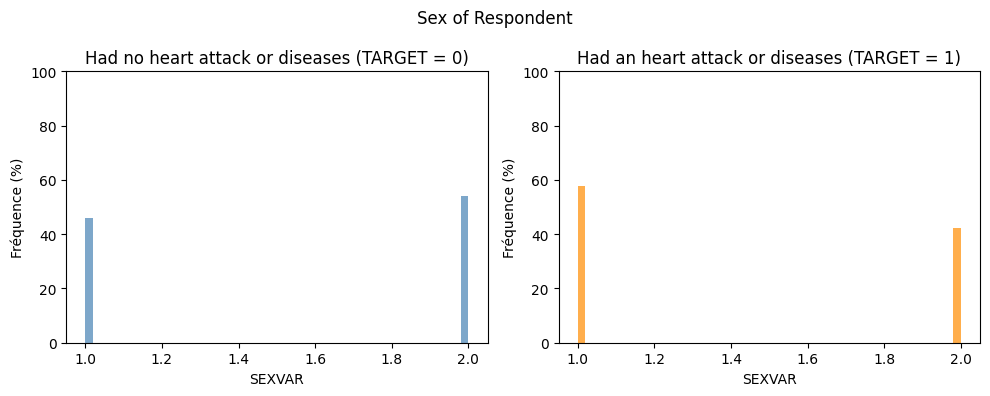

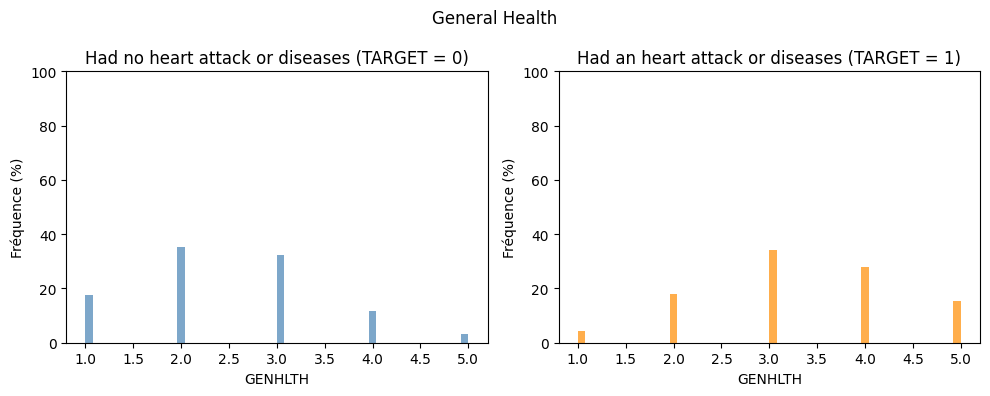

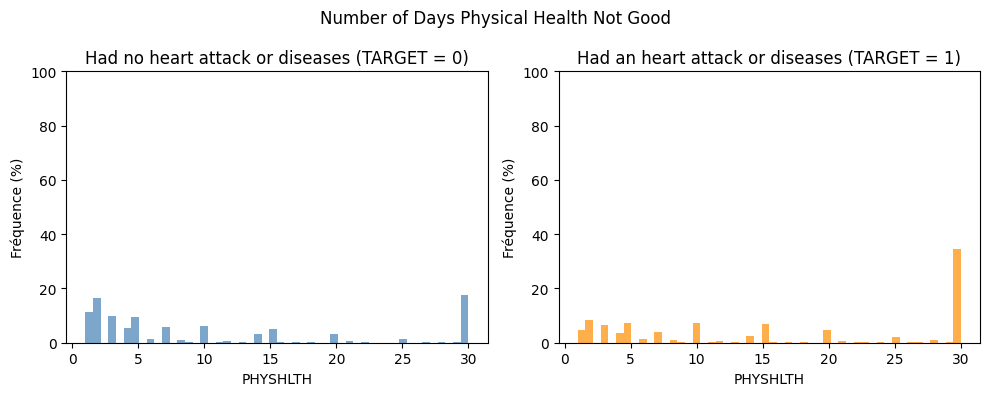

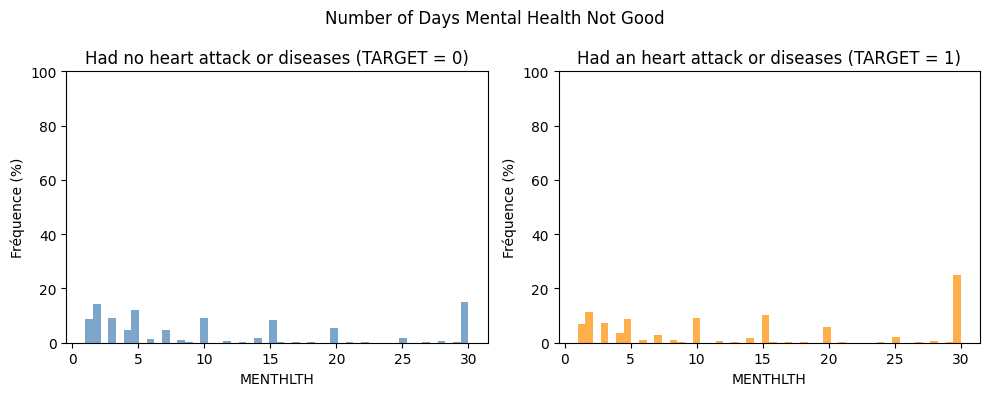

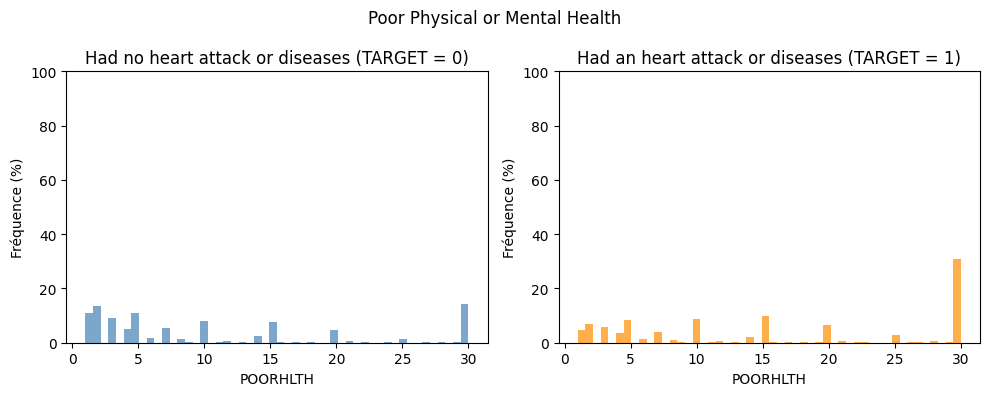

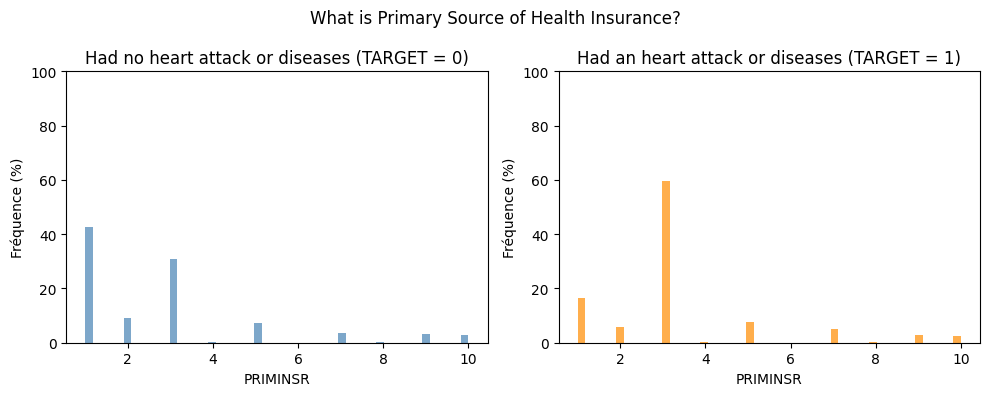

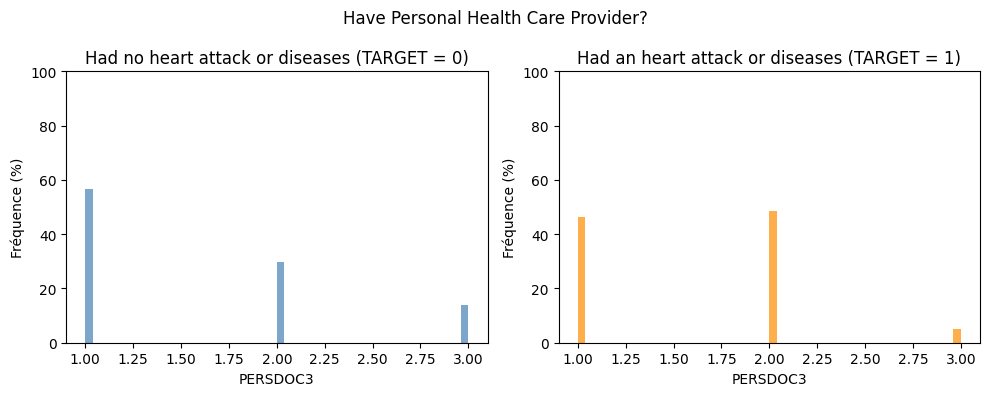

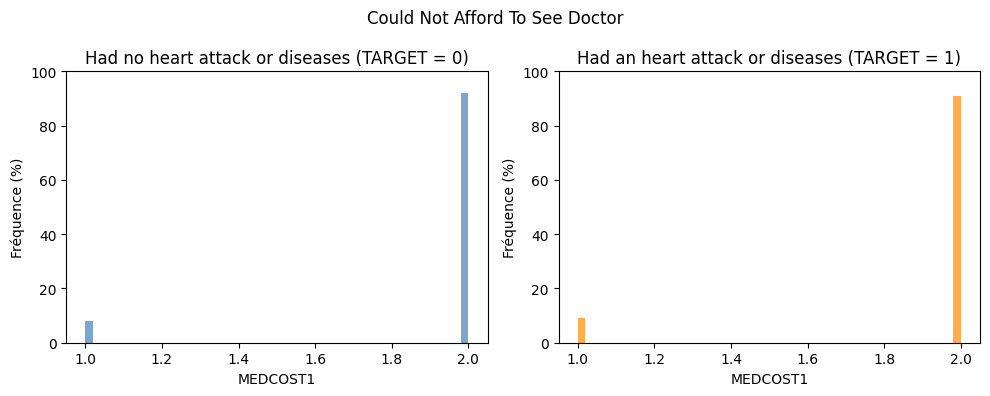

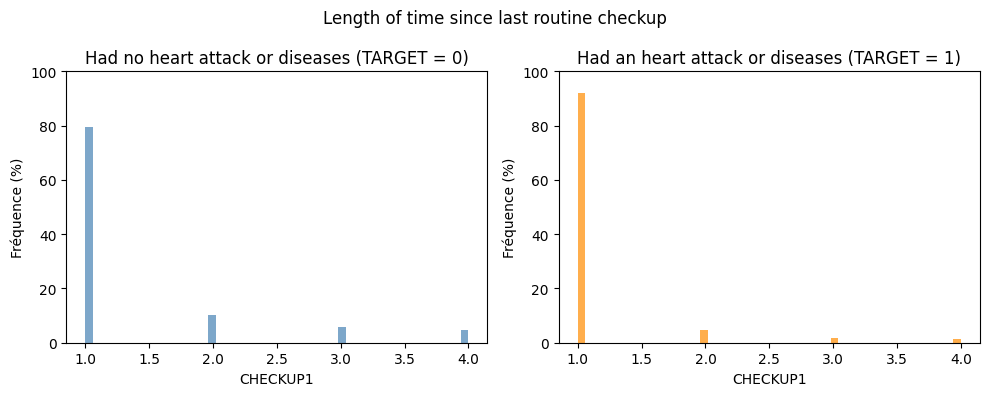

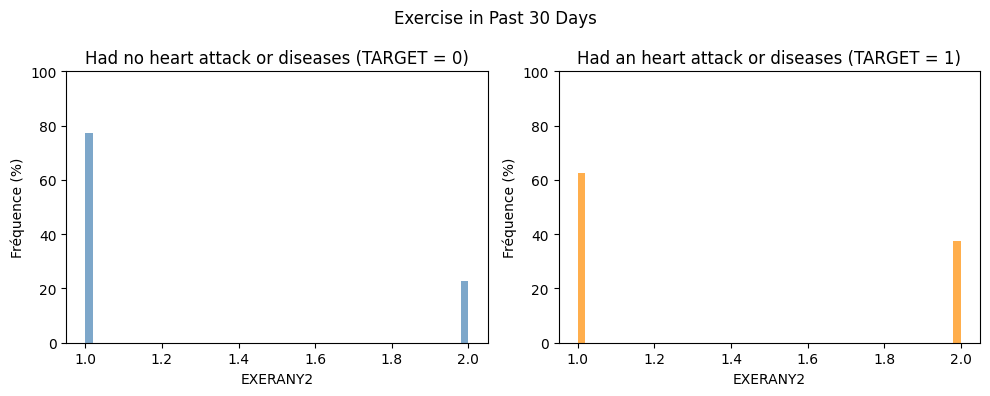

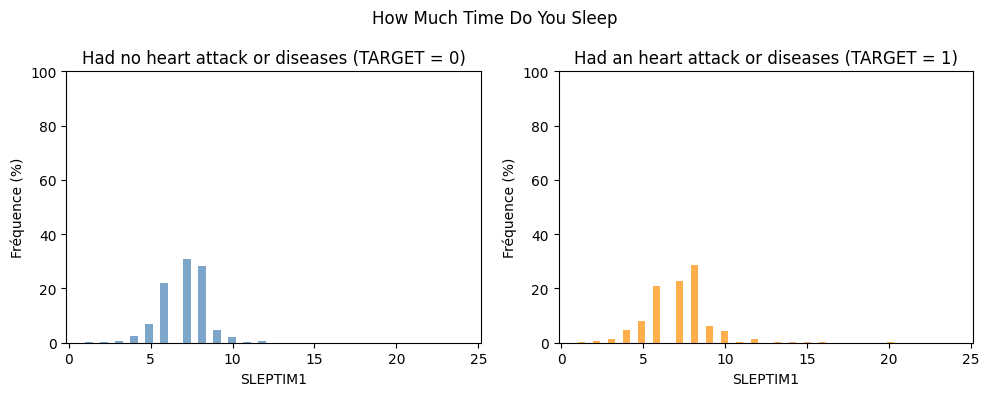

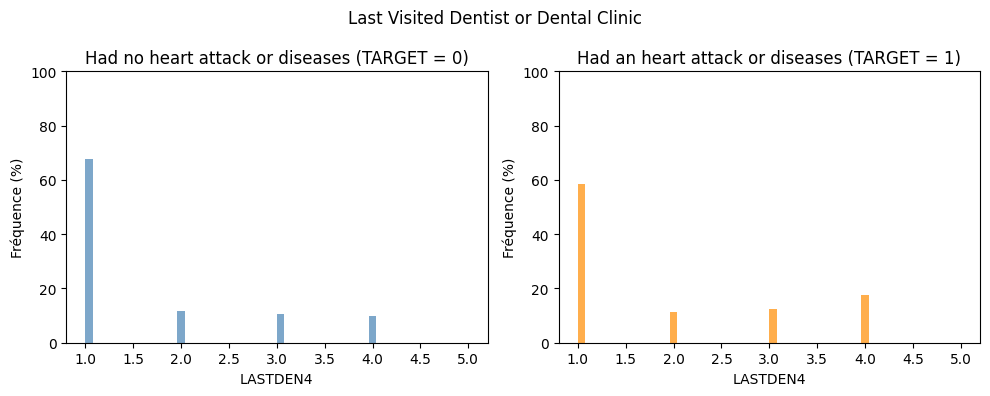

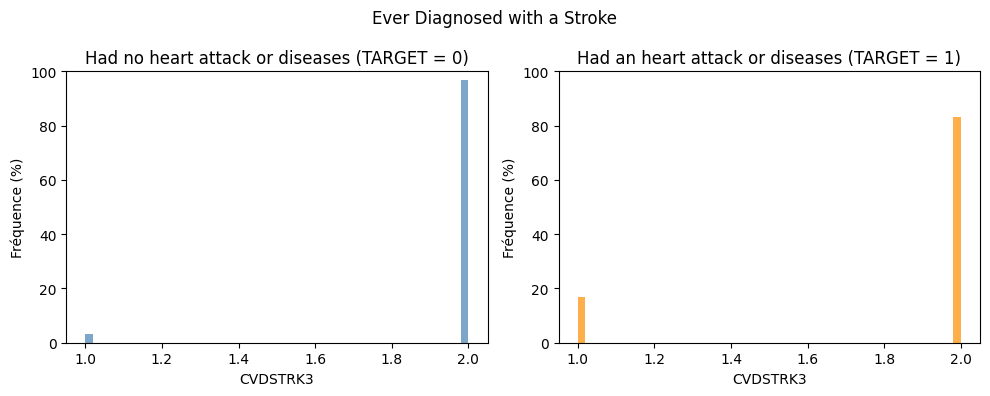

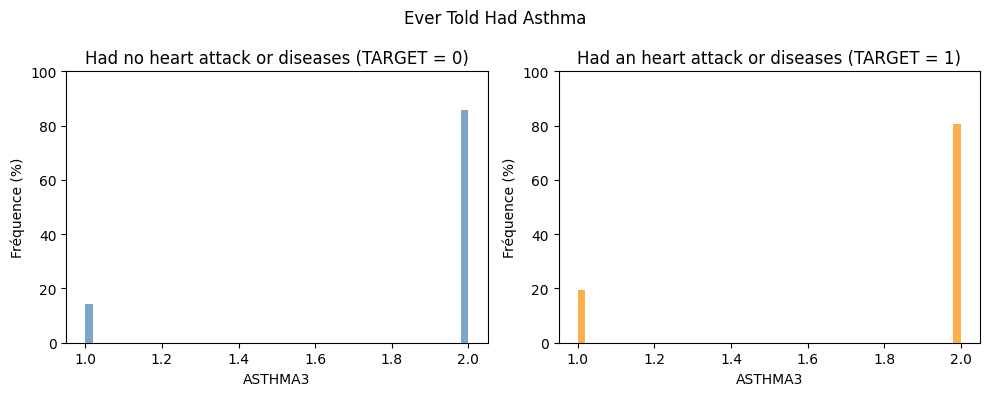

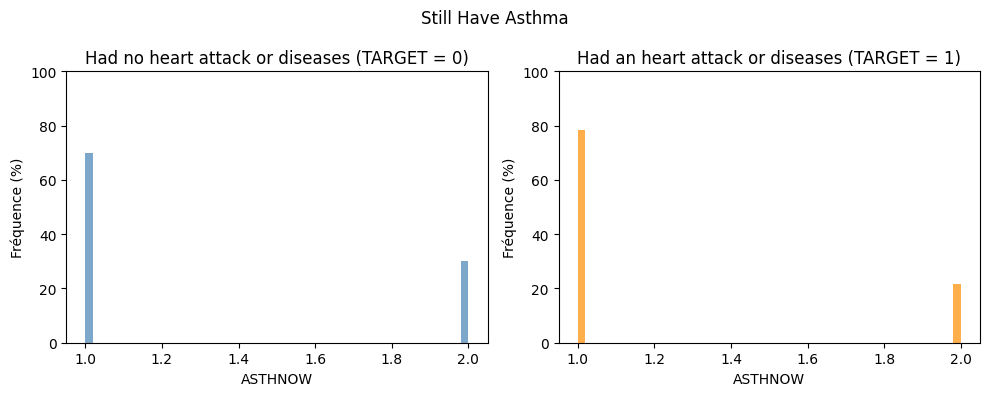

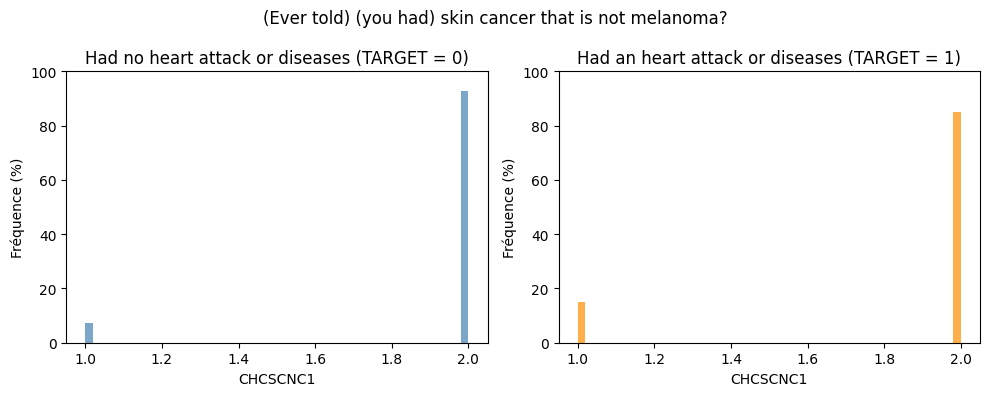

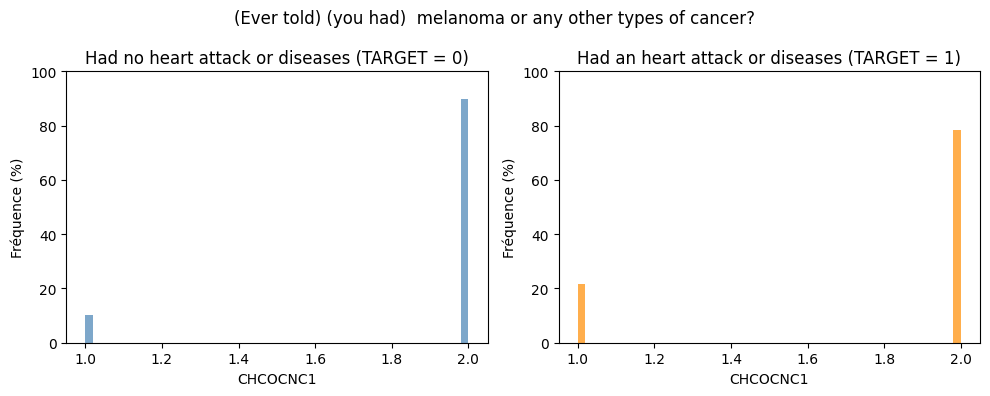

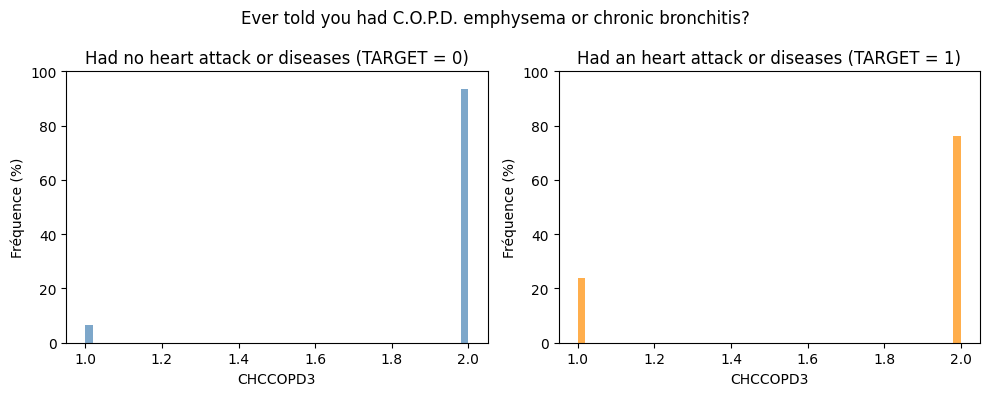

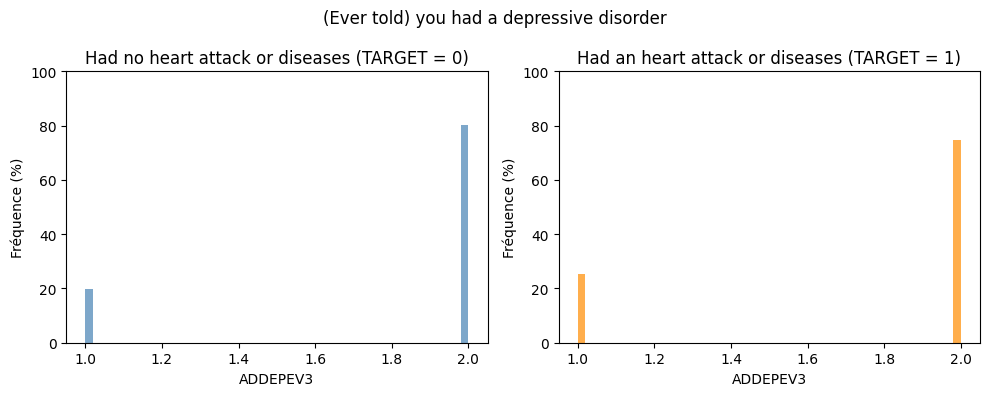

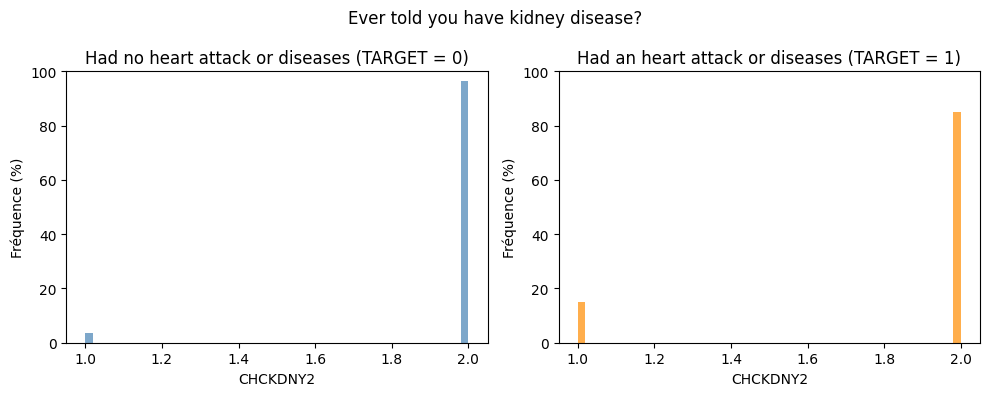

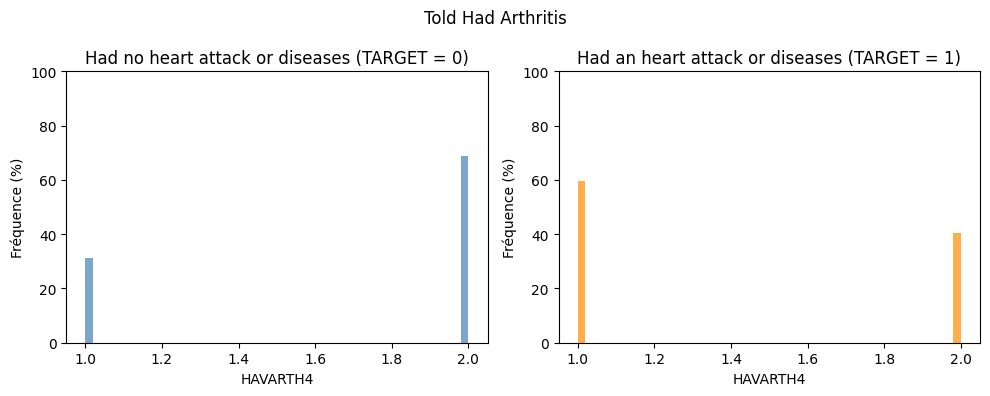

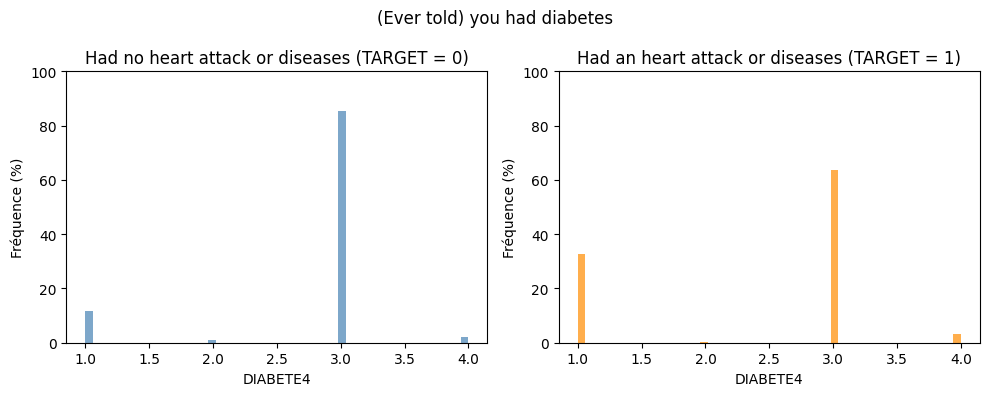

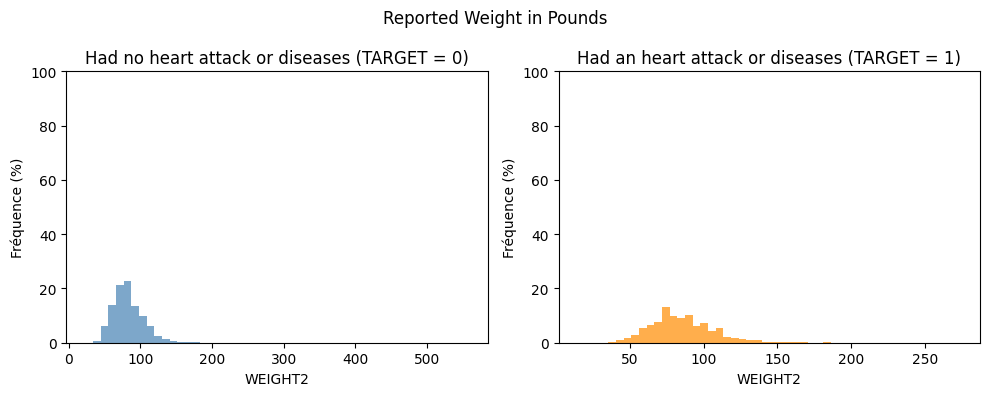

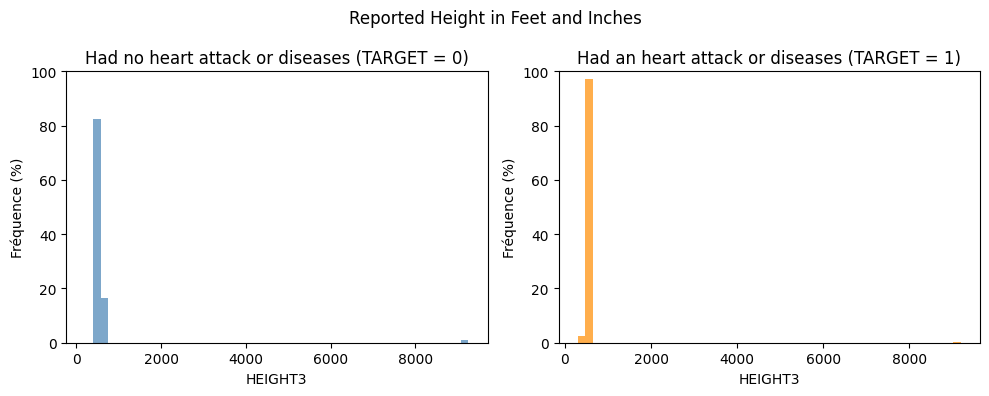

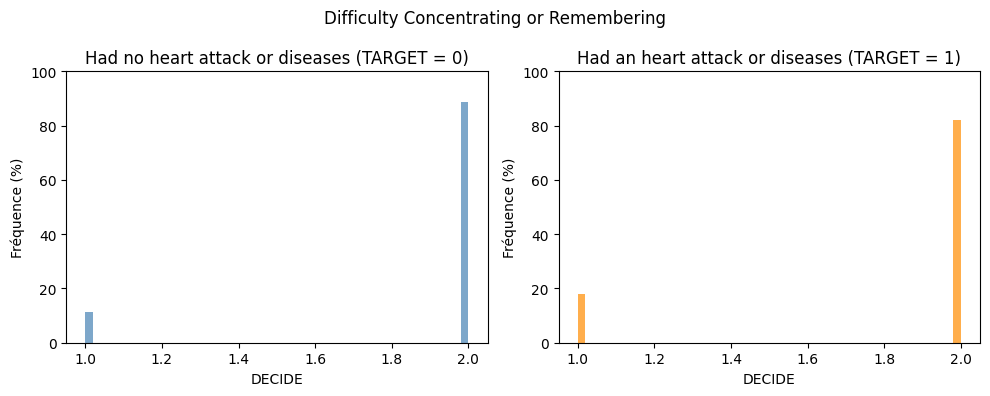

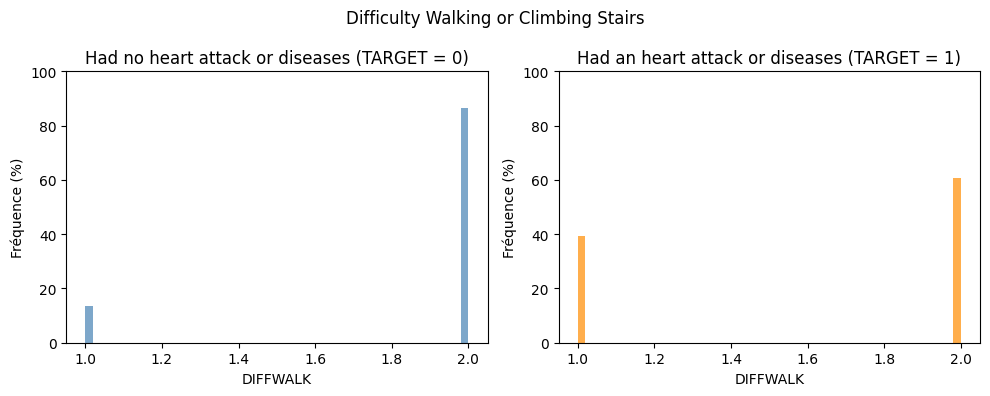

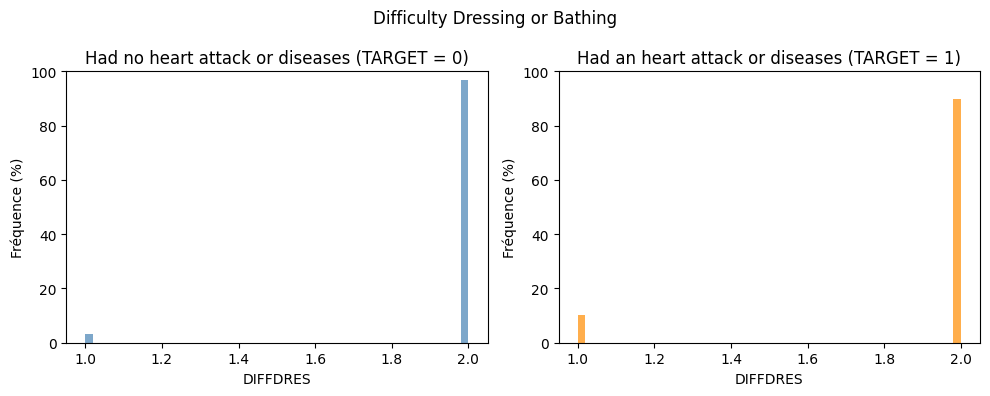

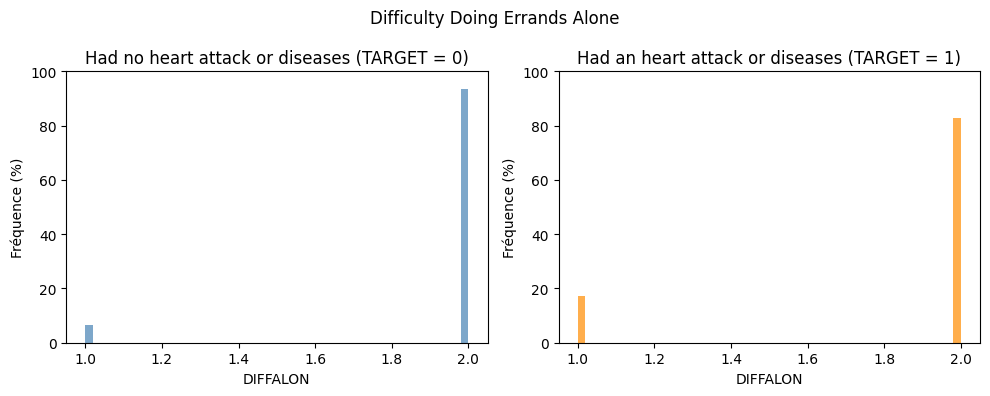

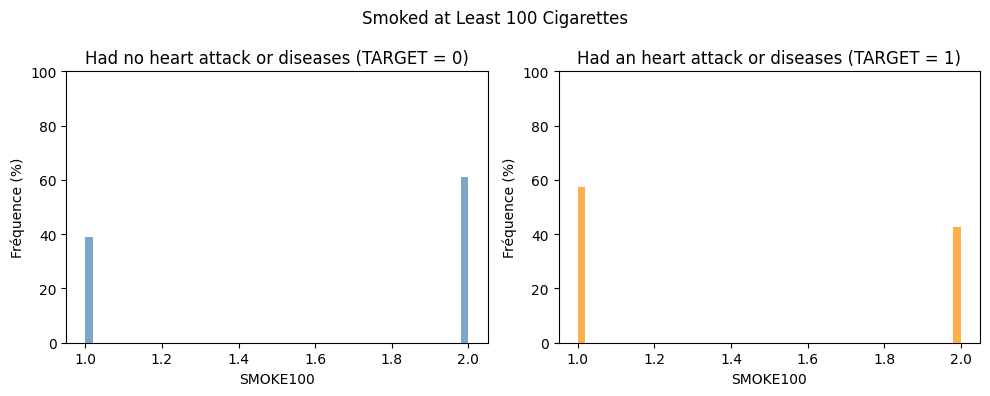

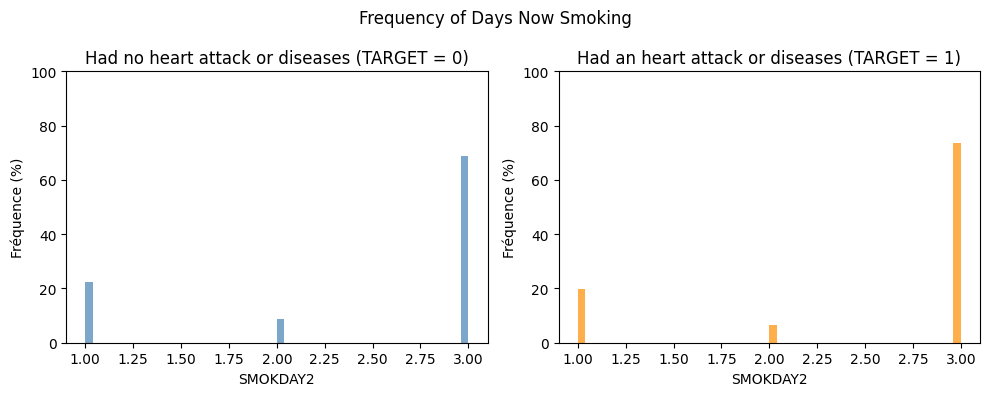

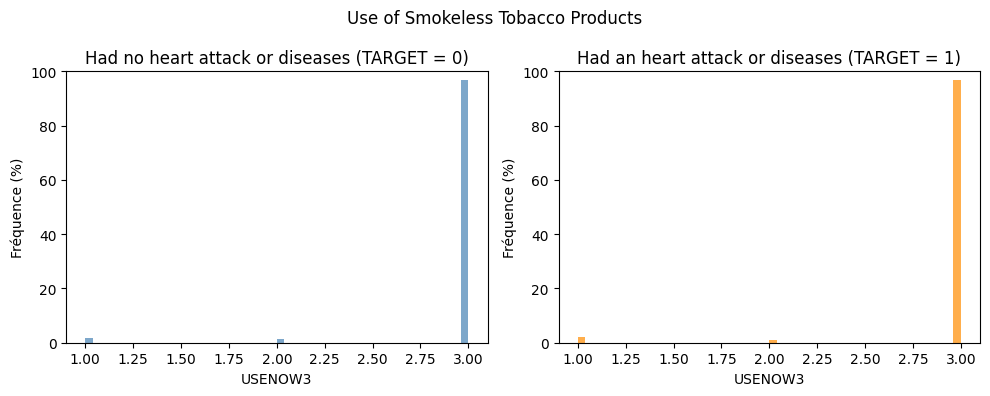

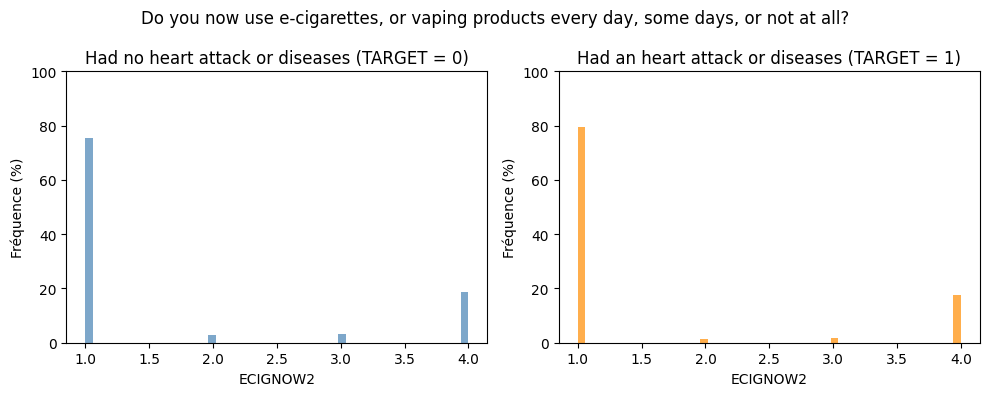

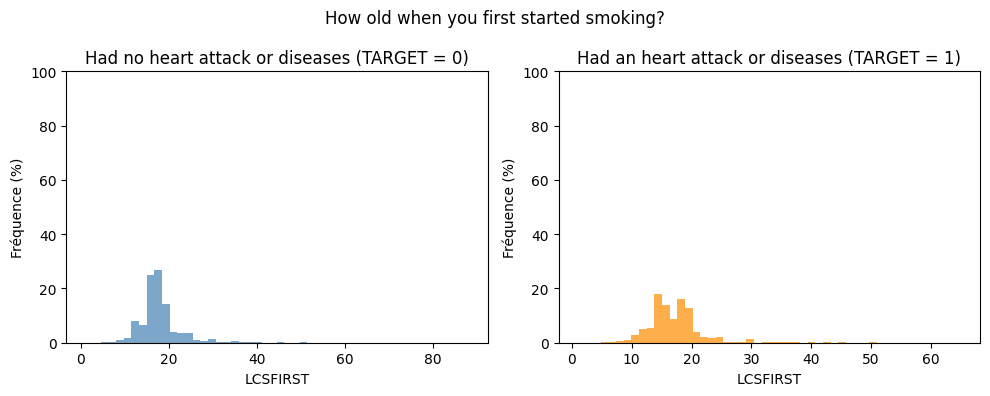

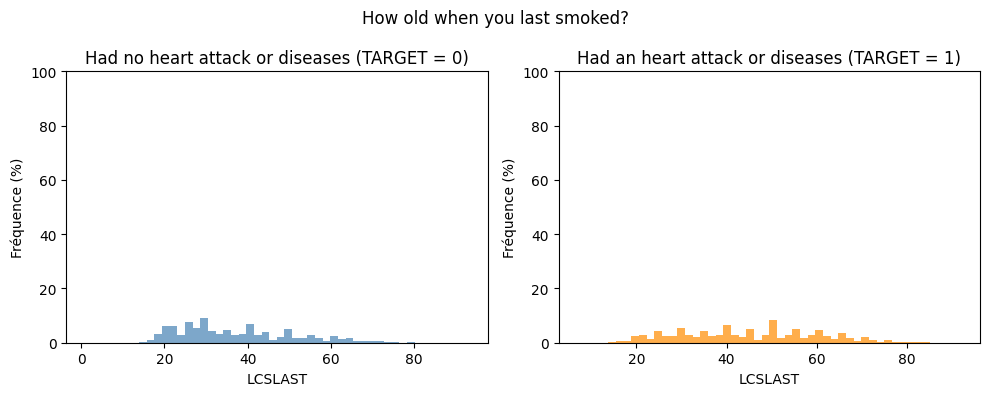

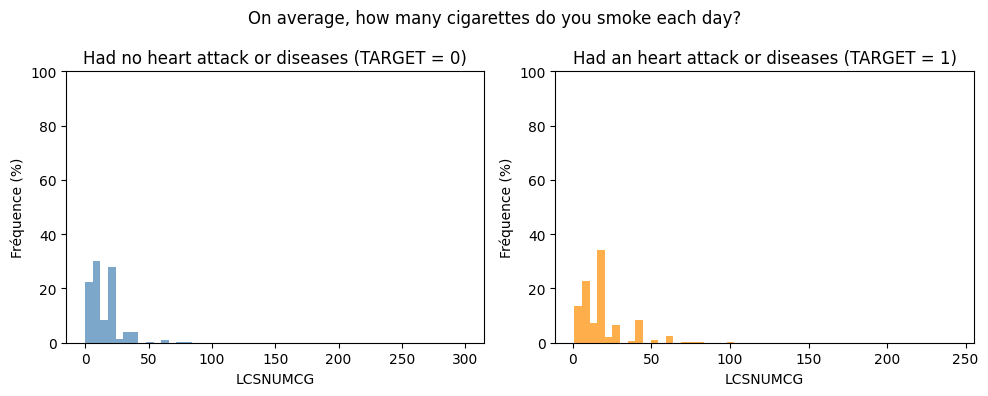

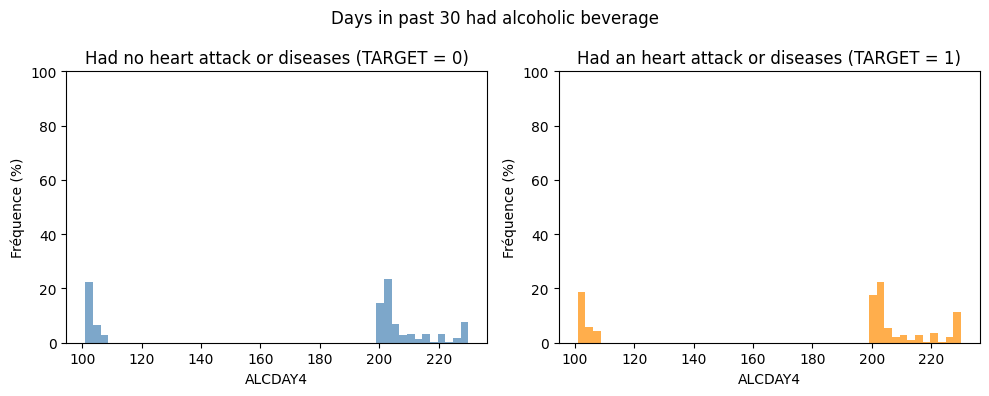

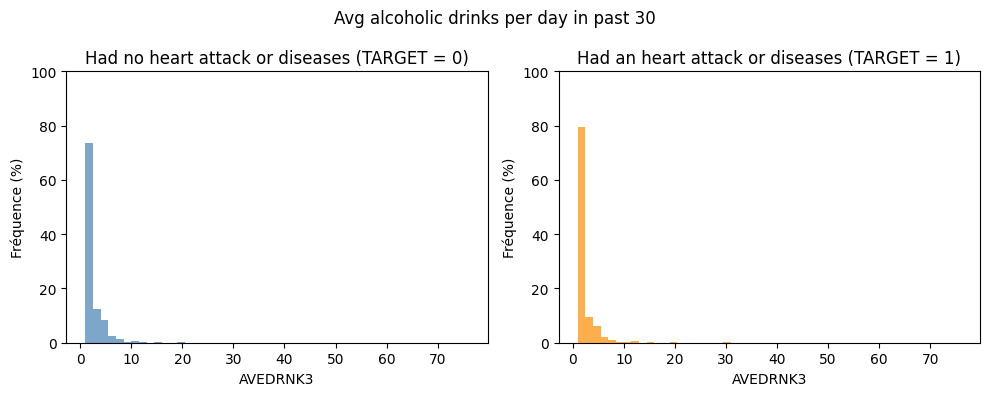

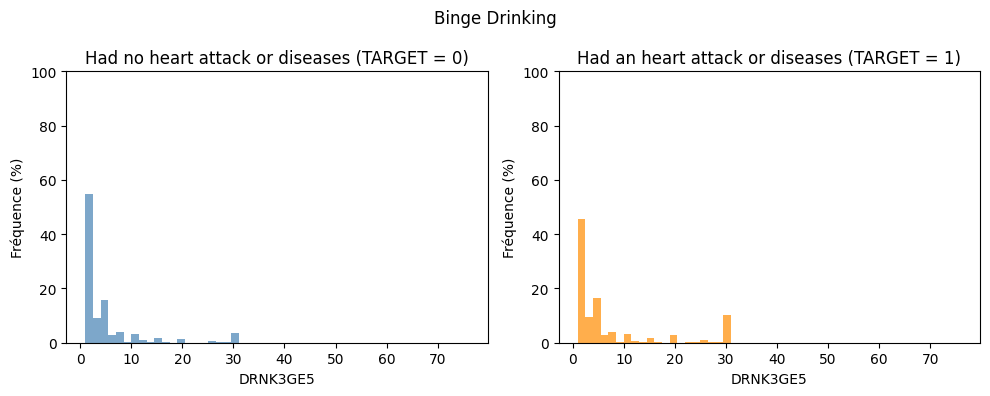

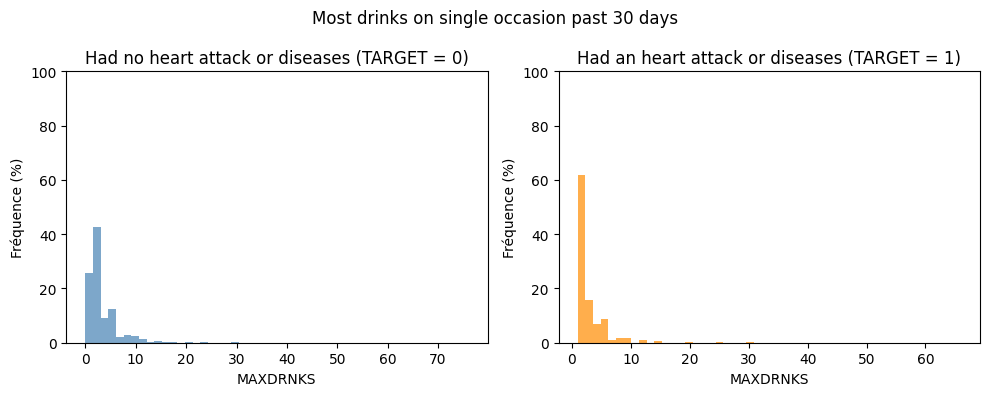

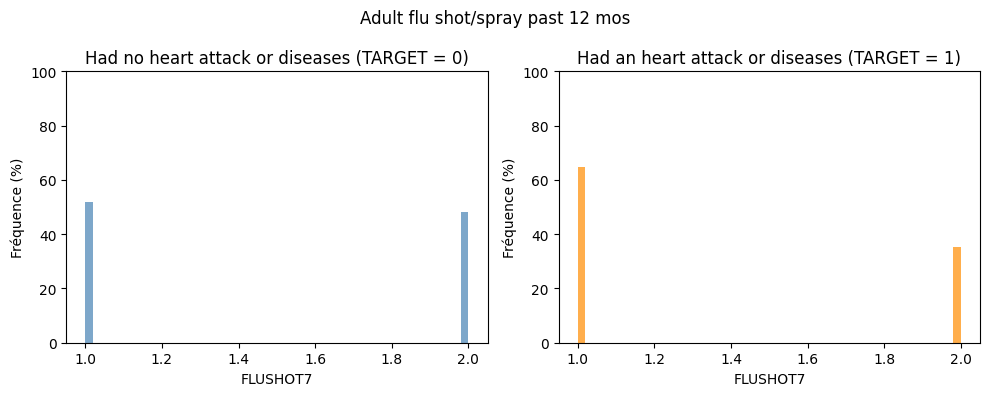

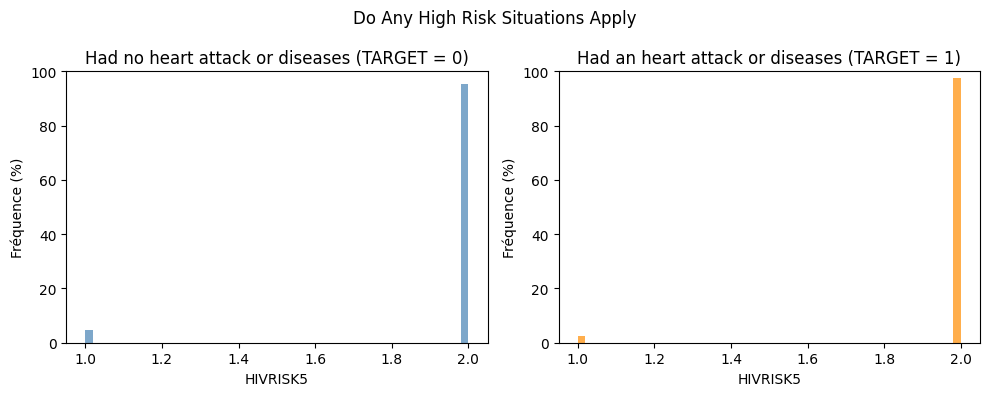

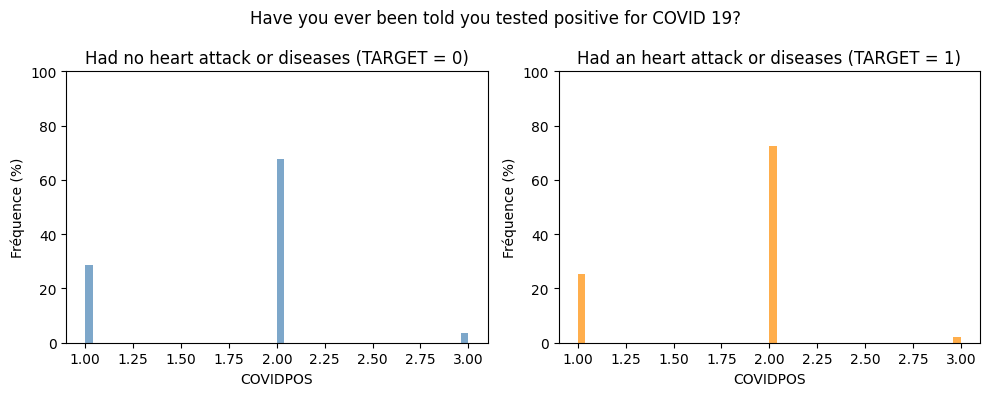

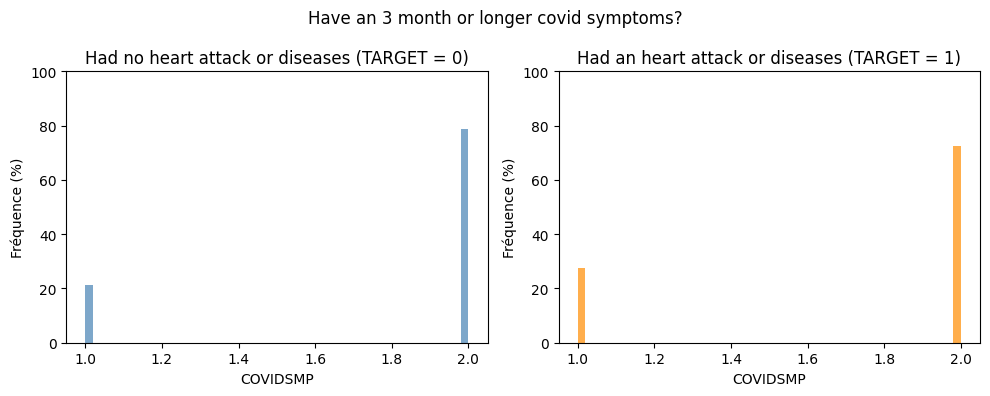

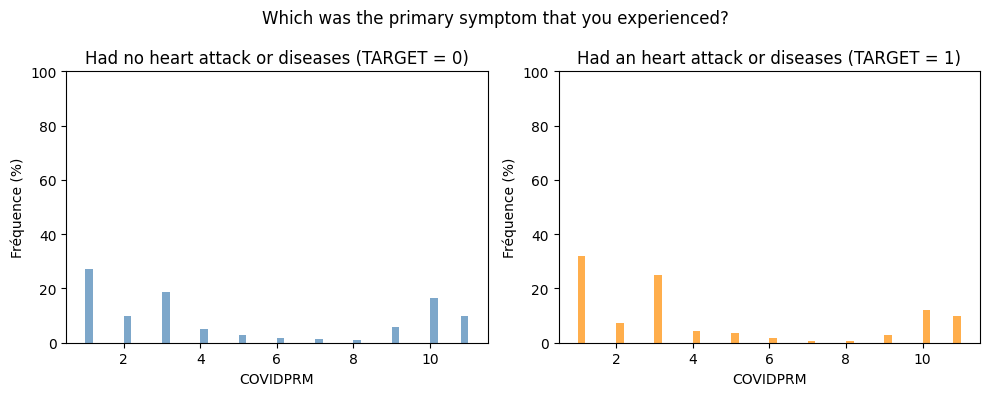

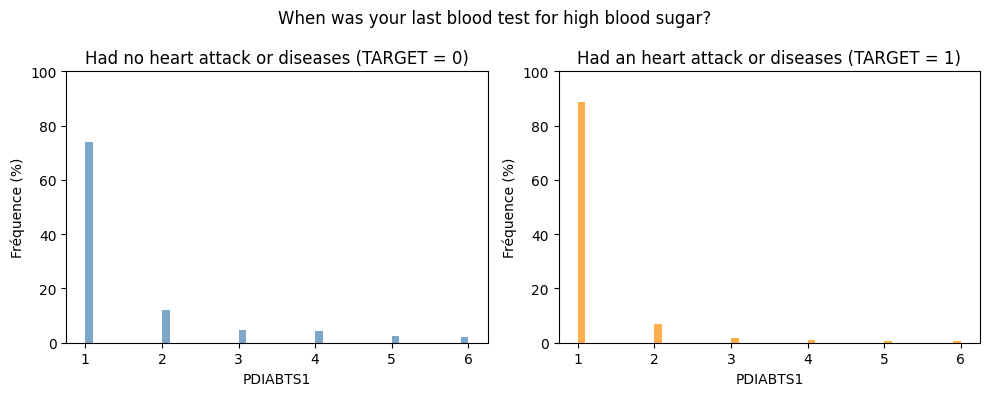

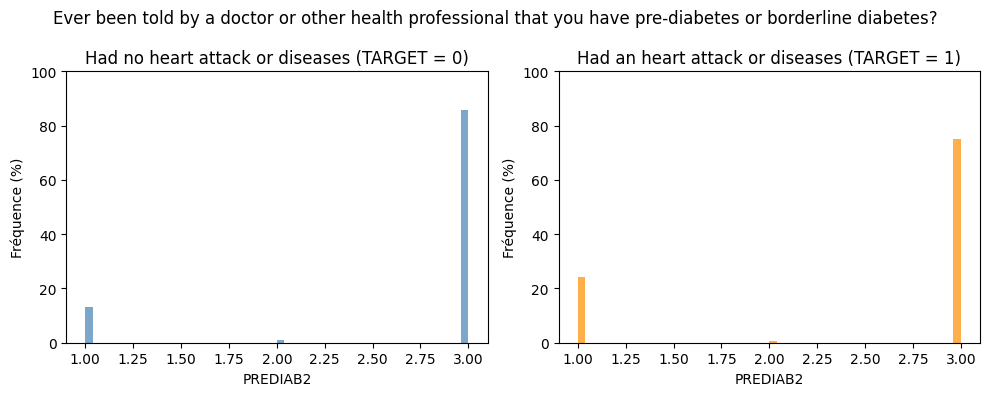

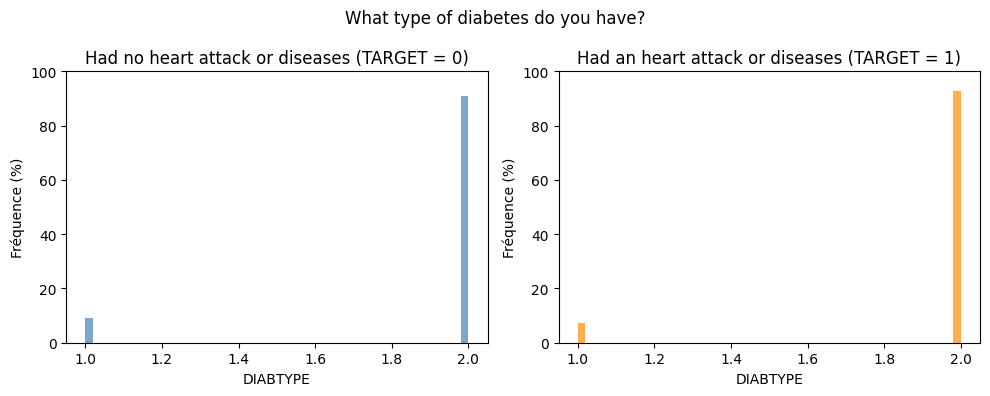

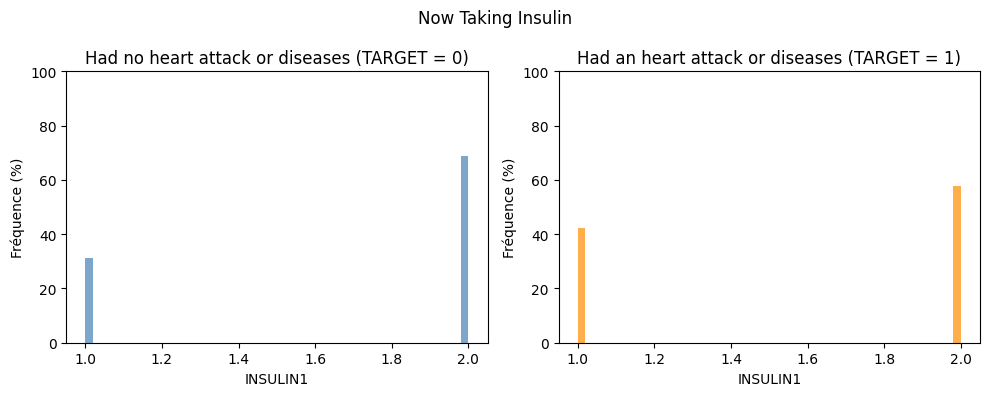

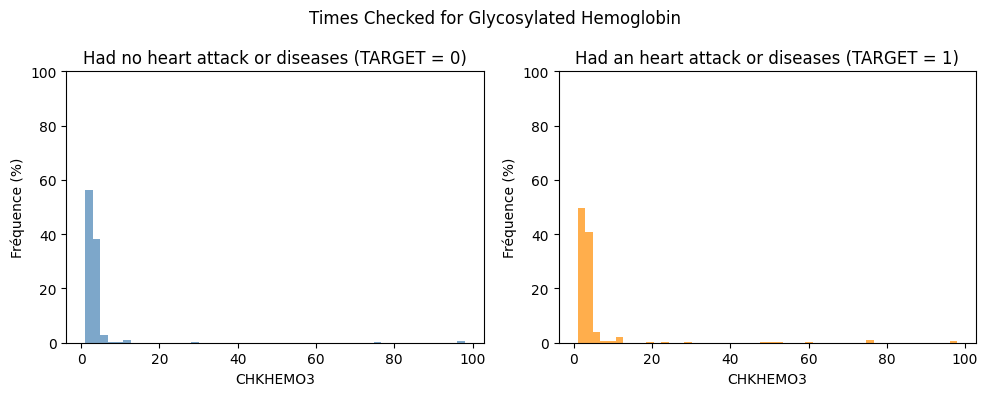

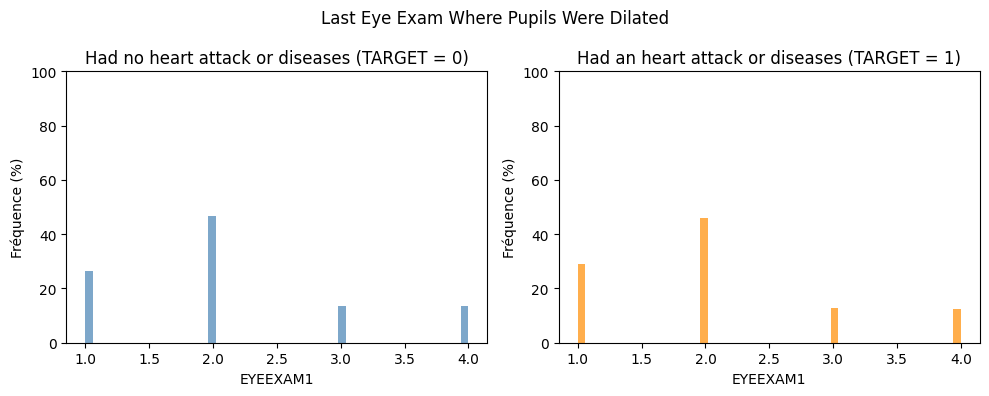

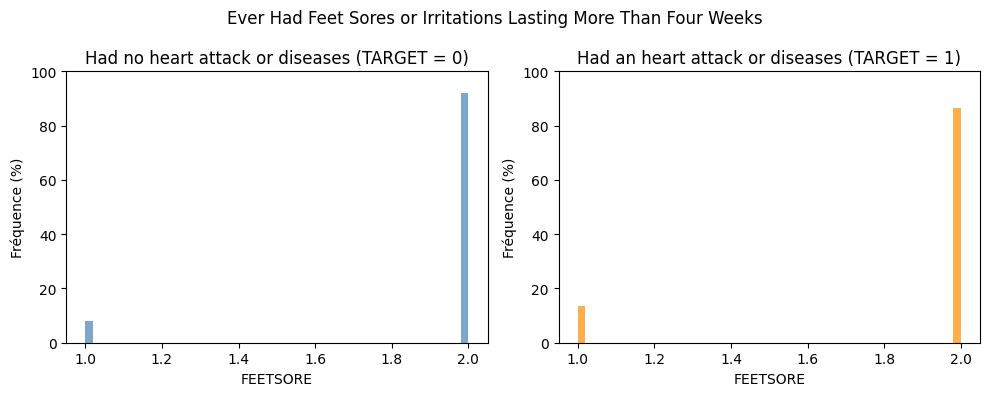

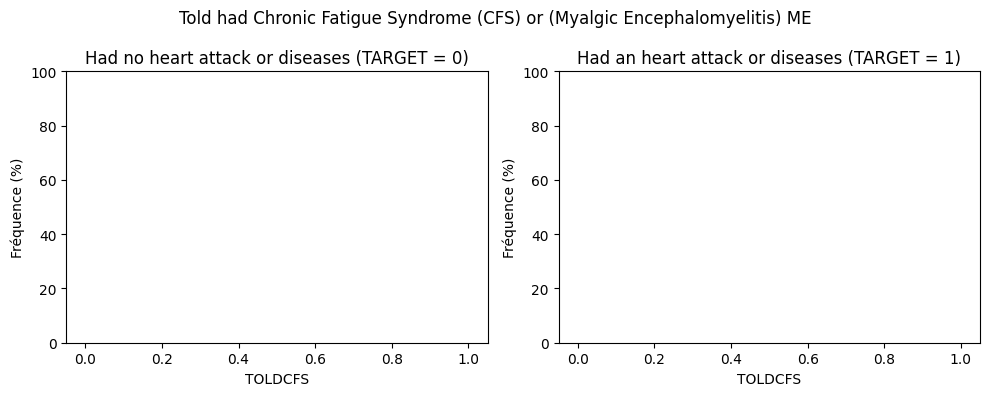

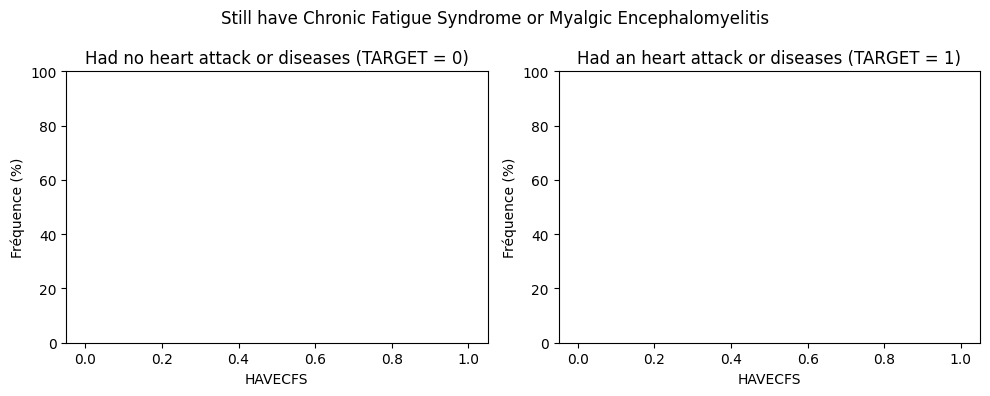

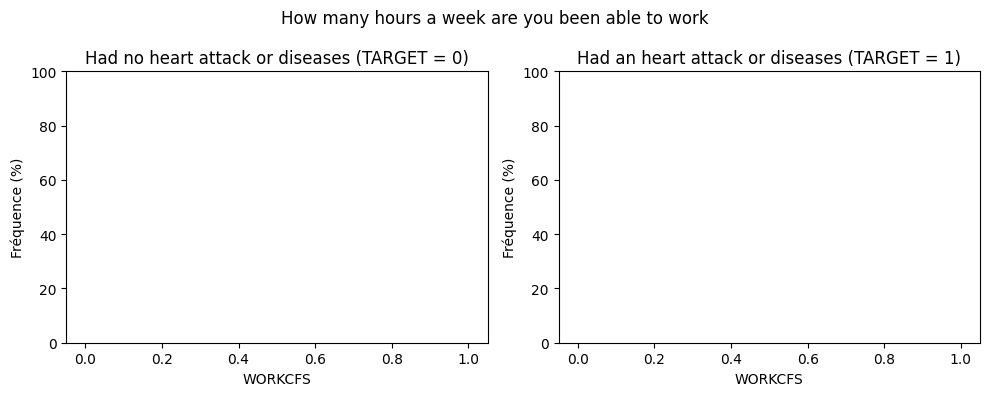

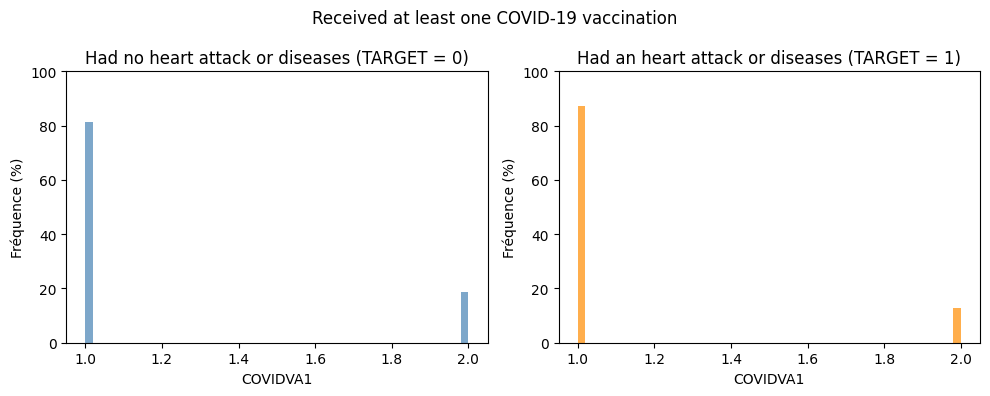

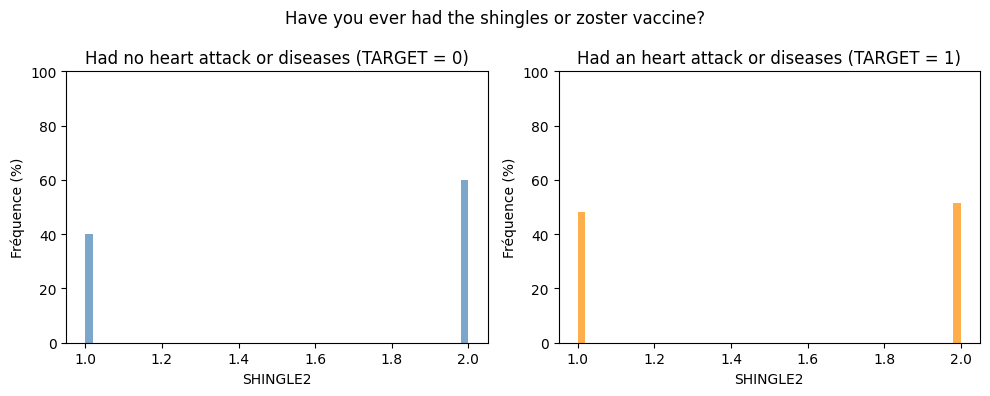

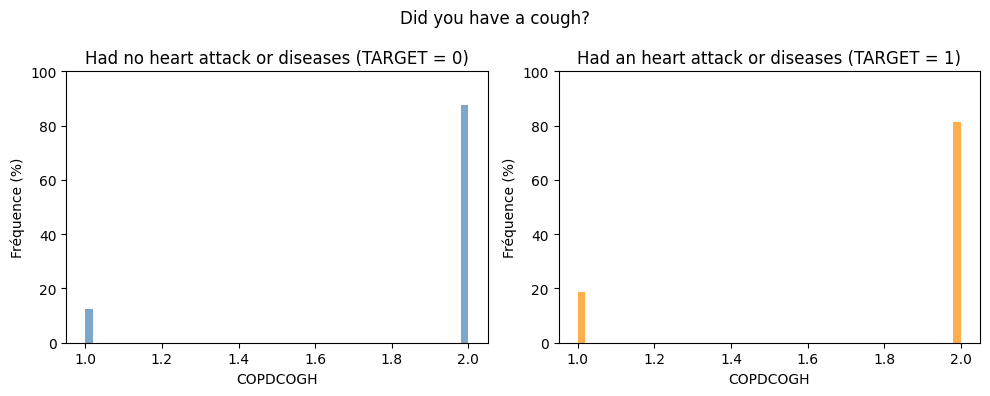

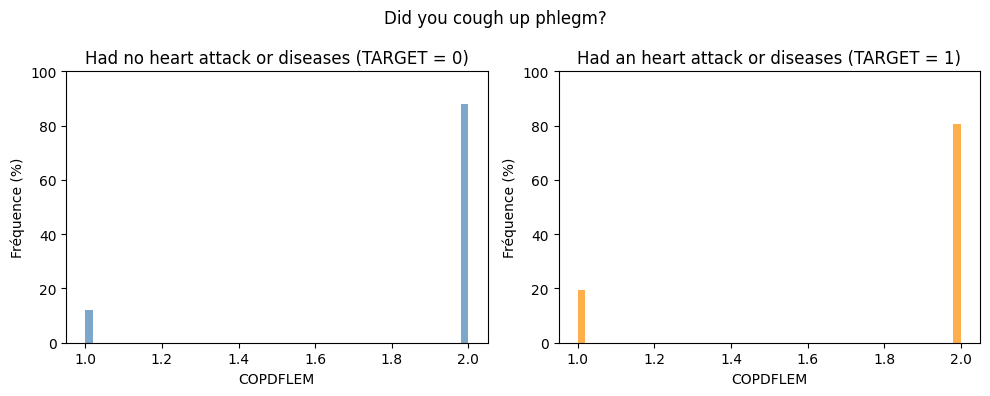

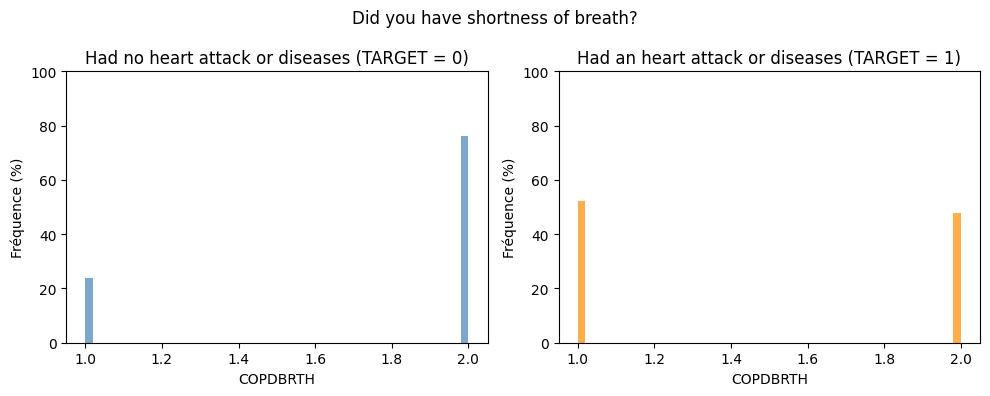

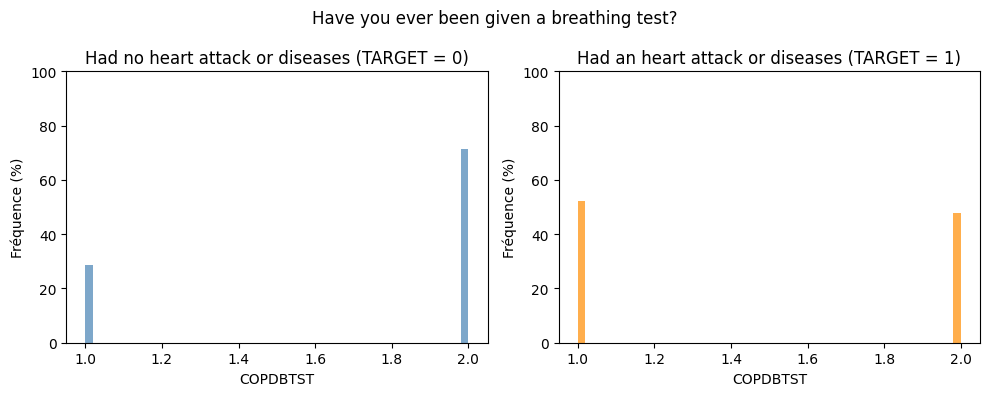

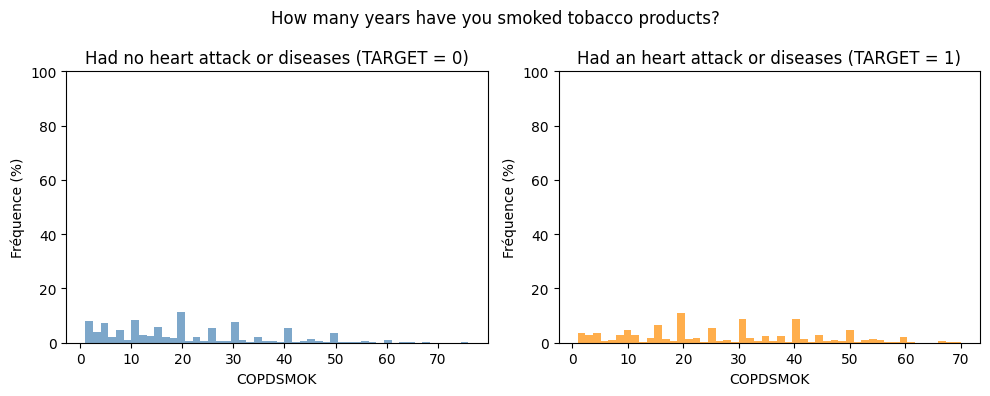

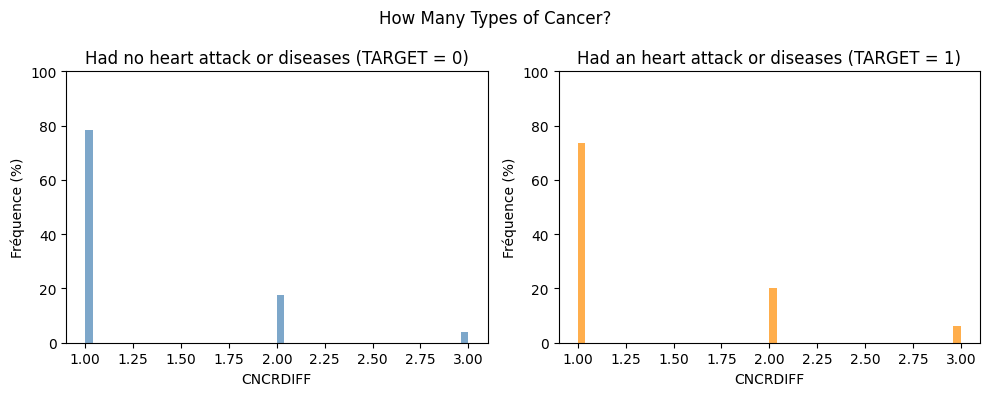

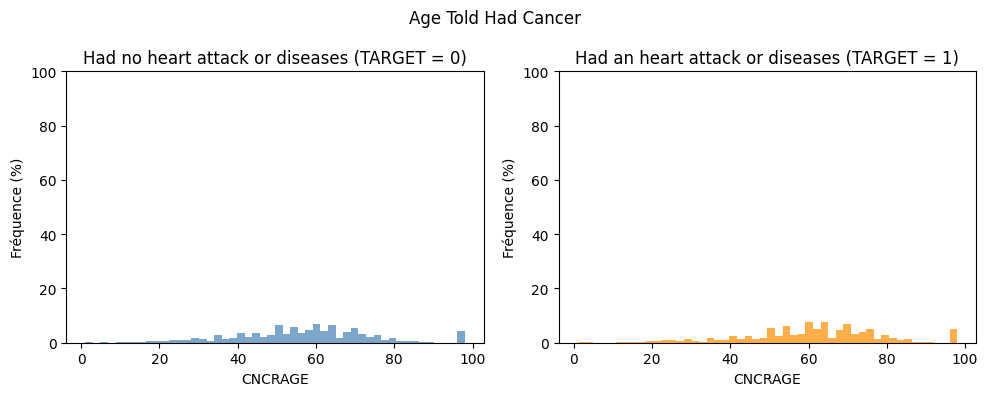

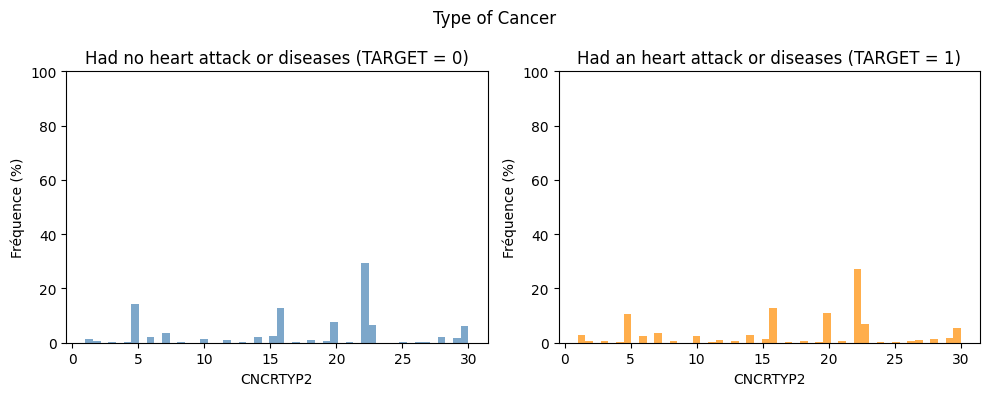

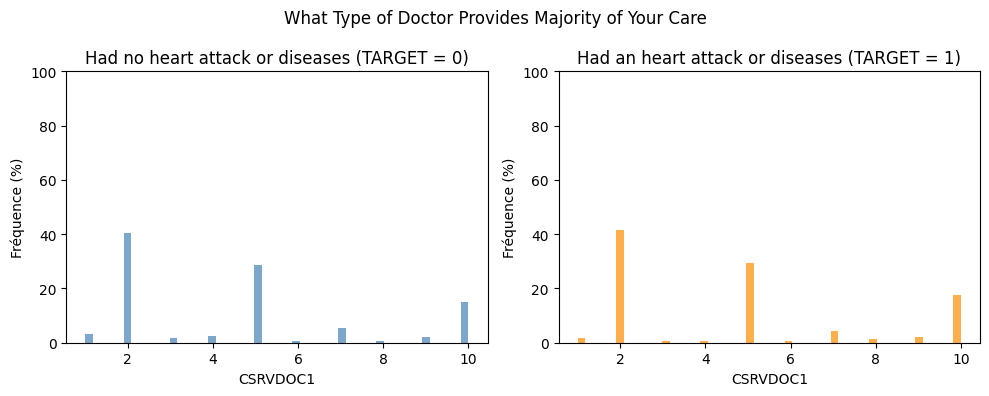

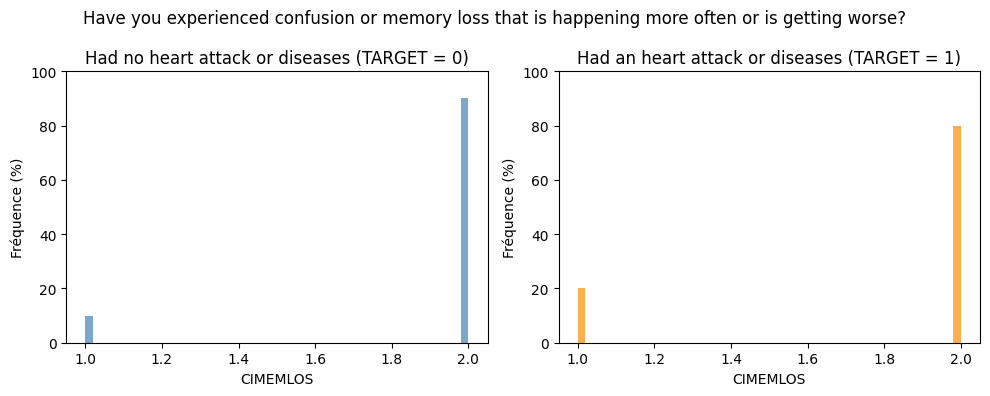

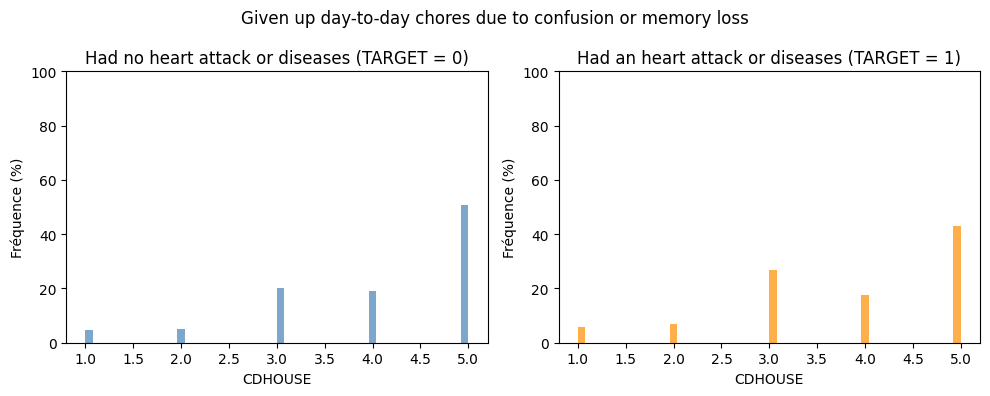

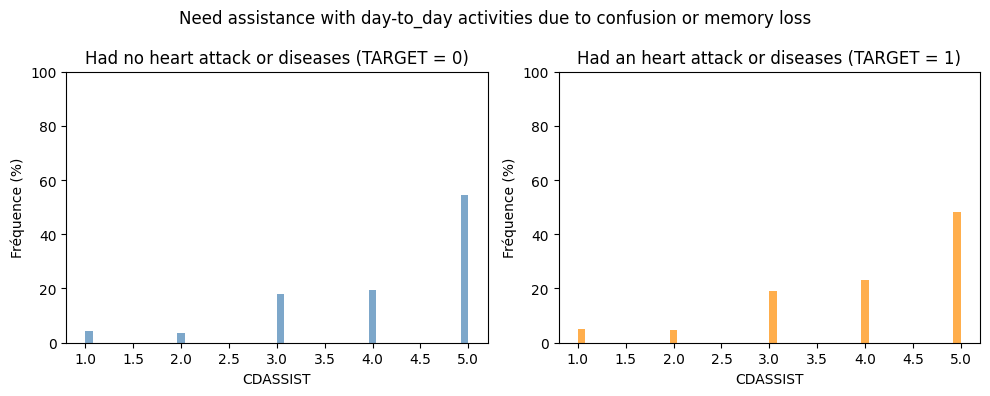

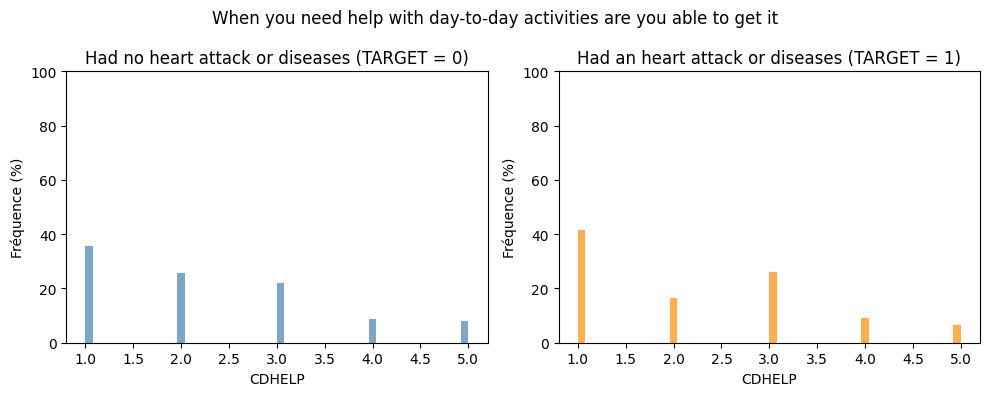

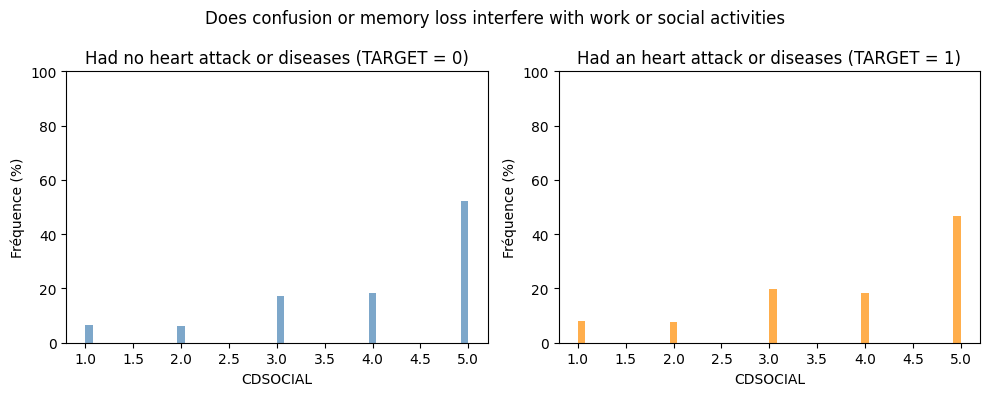

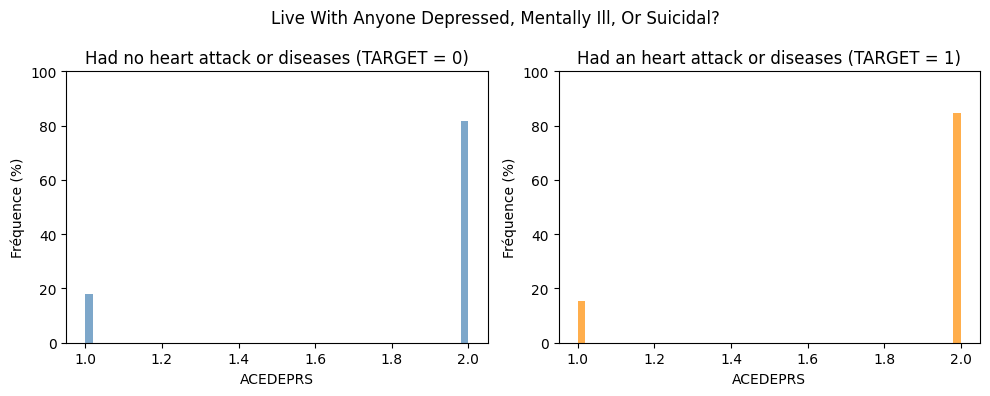

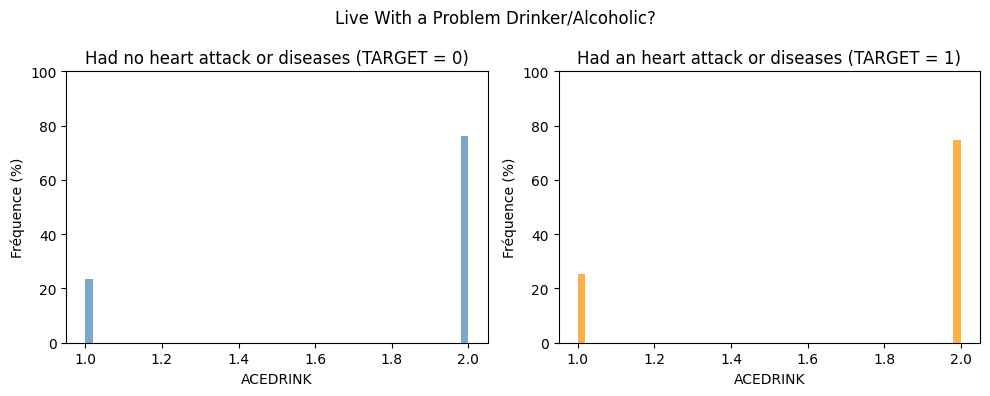

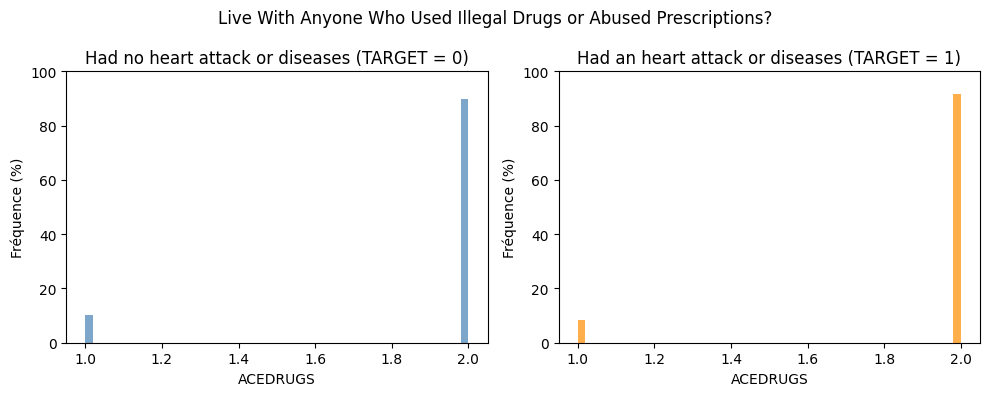

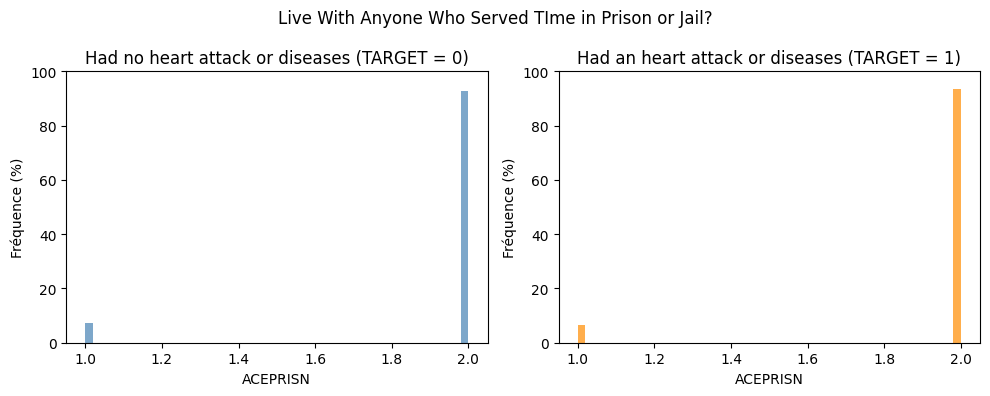

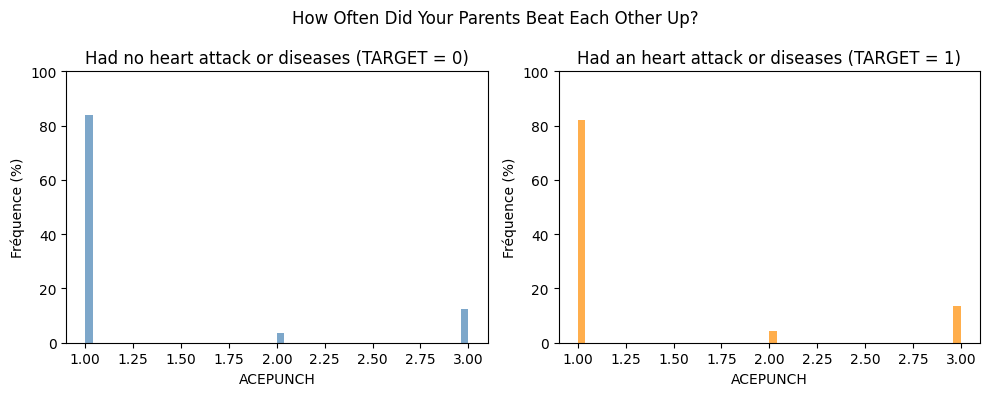

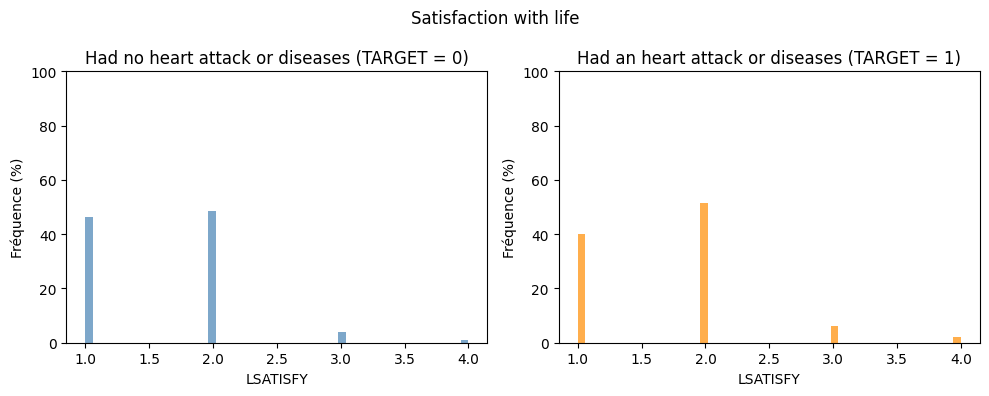

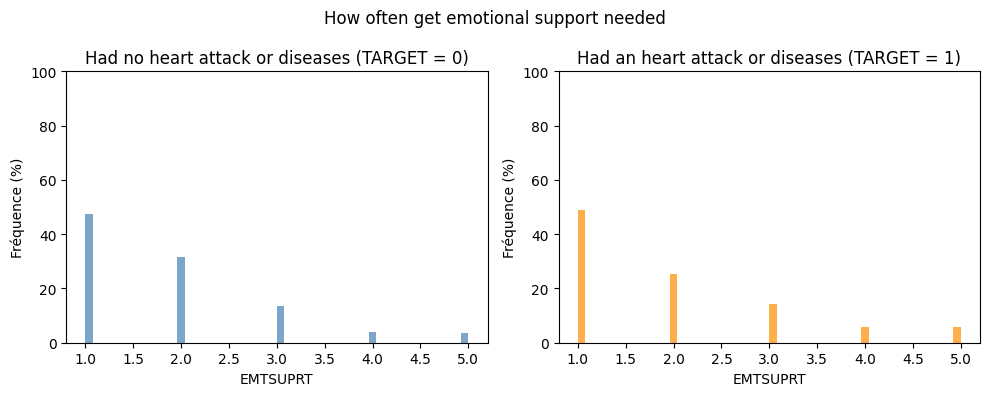

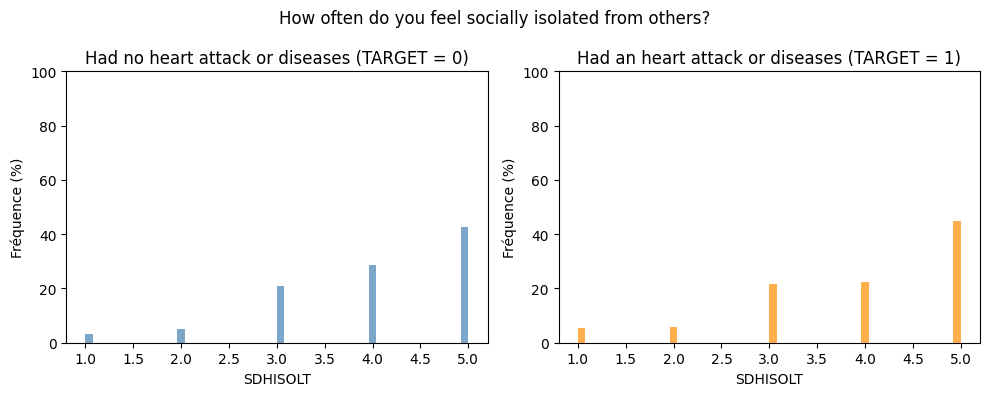

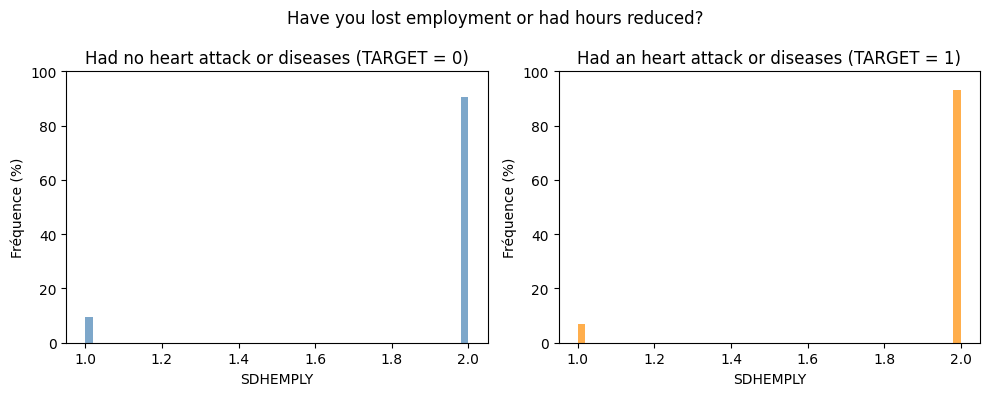

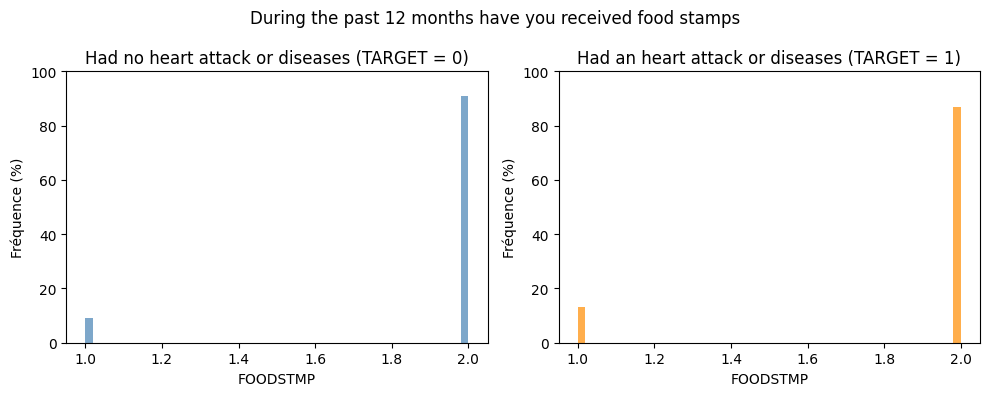

/var/folders/hf/cz9pm8_16vs_zz16xs5lw1xc0000gn/T/ipykernel_5795/1115350999.py:48: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 146 (\x92) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


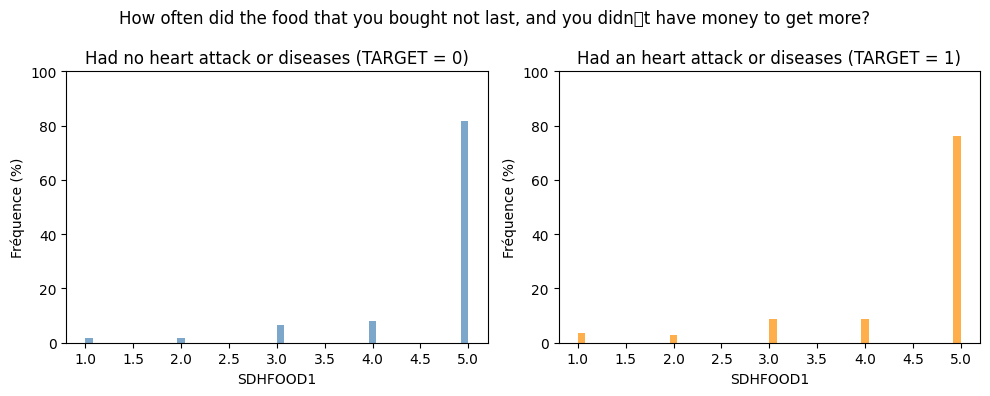

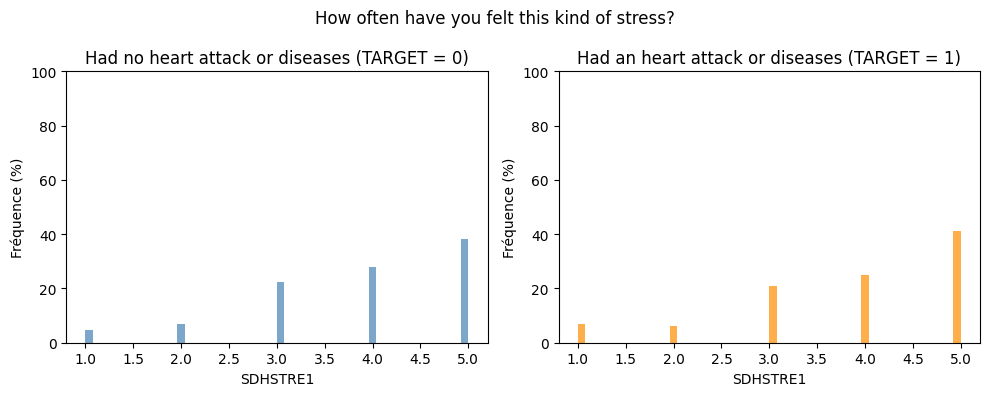

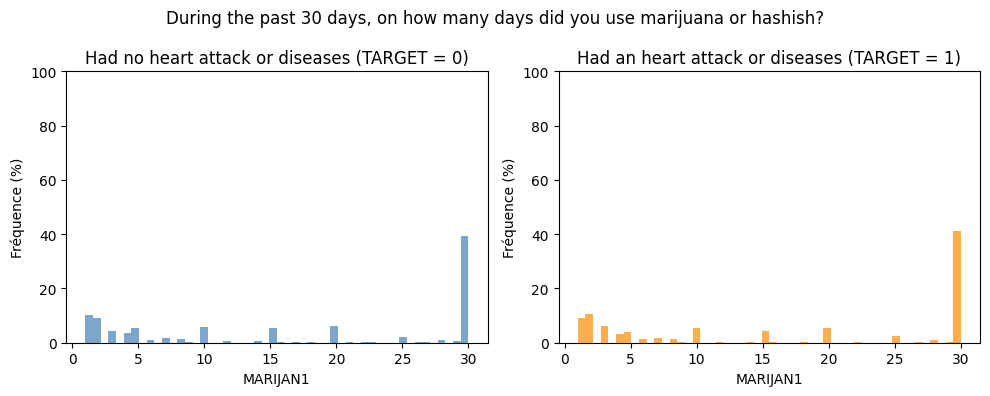

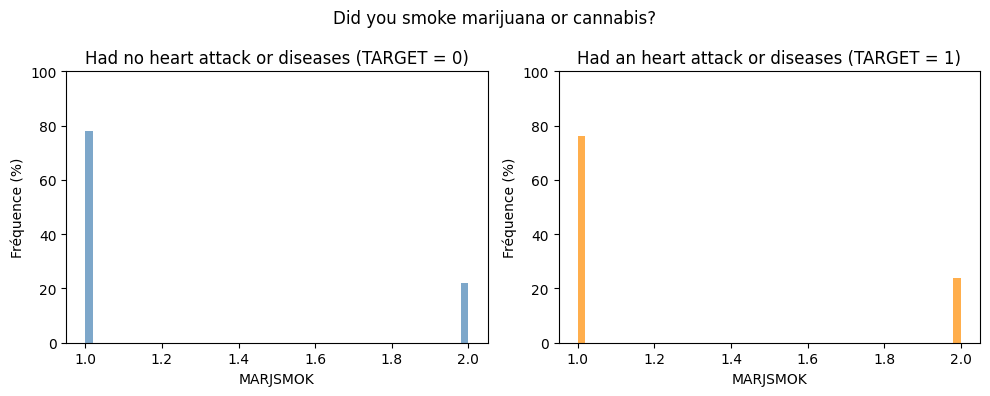

In [28]:
max_cols = 20
bins = 50

for col in columns_of_interest :  # limiter à max_cols pour éviter trop de plots
    # Ignorer les NaN
    data = features[col]
    target_clean = target.loc[data.index]

    # ❌ Exclure les 0 et -1
    mask_valid = (data != 0) & (data != -1)
    data = data[mask_valid]
    target_clean = target_clean[mask_valid]

    # Séparer les valeurs selon la cible
    data_0 = data[target_clean == 0]
    data_1 = data[target_clean == 1]

    # Créer la figure
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"{parsed_dict[col]}", fontsize=12)

    # Histogramme pour TARGET = 0
    axes[0].hist(
        data_0,
        bins=bins,
        weights=np.ones(len(data_0)) / len(data_0) * 100,
        alpha=0.7,
        color="steelblue"
    )
    axes[0].set_title("Had no heart attack or diseases (TARGET = 0)")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel("Fréquence (%)")
    axes[0].set_ylim(0, 100)

    # Histogramme pour TARGET = 1
    axes[1].hist(
        data_1,
        bins=bins,
        weights=np.ones(len(data_1)) / len(data_1) * 100,
        alpha=0.7,
        color="darkorange"
    )
    axes[1].set_title("Had an heart attack or diseases (TARGET = 1)")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Fréquence (%)")
    axes[1].set_ylim(0, 100)

    plt.tight_layout()
    plt.show()

### Plot des histogrammes